In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import os, json

In [3]:
from vb_helper import VBHelper

kwargs=dict(
    shuffle=True,
    drop_duplicates='Xy',#'X',False
    nan_threshold=0.9,#drop any column with more than this share of nulls
    run_stacked=True, 
    test_share=0,
    cv_folds=5,
    cv_reps=10,
    cv_strategy=None,
    )
vbhelper=VBHelper(**kwargs)

no daal4py


In [4]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #strings defined in scikit-learn
vbhelper.scorer_list=scorer_list

In [5]:
#load data
data_path=os.path.join('sample_data','ex3.csv')
df=pd.read_csv(data_path)
df.index=[str(i) for i in df.index]
#select variables
y_name='entero_cfu'
loc_vars=[]
drop_vars=['Date']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
all_vars=list(df.columns)
x_vars=[var for var in all_vars if var not in drop_vars]

#extract random rows for prediction
predict_n=3
shuf=np.arange(df.shape[0])
seed=0
rng = np.random.default_rng(seed)
rng.shuffle(shuf)
predict_select=shuf[:predict_n]
X_predict=df.loc[:,x_vars].iloc[predict_select]
y_predict=df.loc[:,y_name].iloc[predict_select]
predict_loc=[df.index[i] for i in predict_select]
df.drop(index=predict_loc,inplace=True)
X_df=df.loc[:,x_vars]
y_df=df.loc[:,[y_name]]
print(f'indices for predictions: {X_predict.index.to_list()}')

indices for predictions: ['16', '36', '27']


In [6]:
vbhelper.setData(X_df,y_df)

# of duplicate rows of data: 0
# of duplicate rows of X: 0
# of duplicate Xy rows dropped: 0
no columns exceeded nan threshold of 0.9


In [7]:
vbhelper.saveFullFloatXy()

summary data saved to summaryXy.json


In [8]:
from vb_summary import VBSummary
vbs=VBSummary()

with open('summaryXy.json','r') as f:
    data_for_summary=json.load(f)
    
vbs.setData(data_for_summary)

In [9]:
vbs.missingVals()

no missing values found


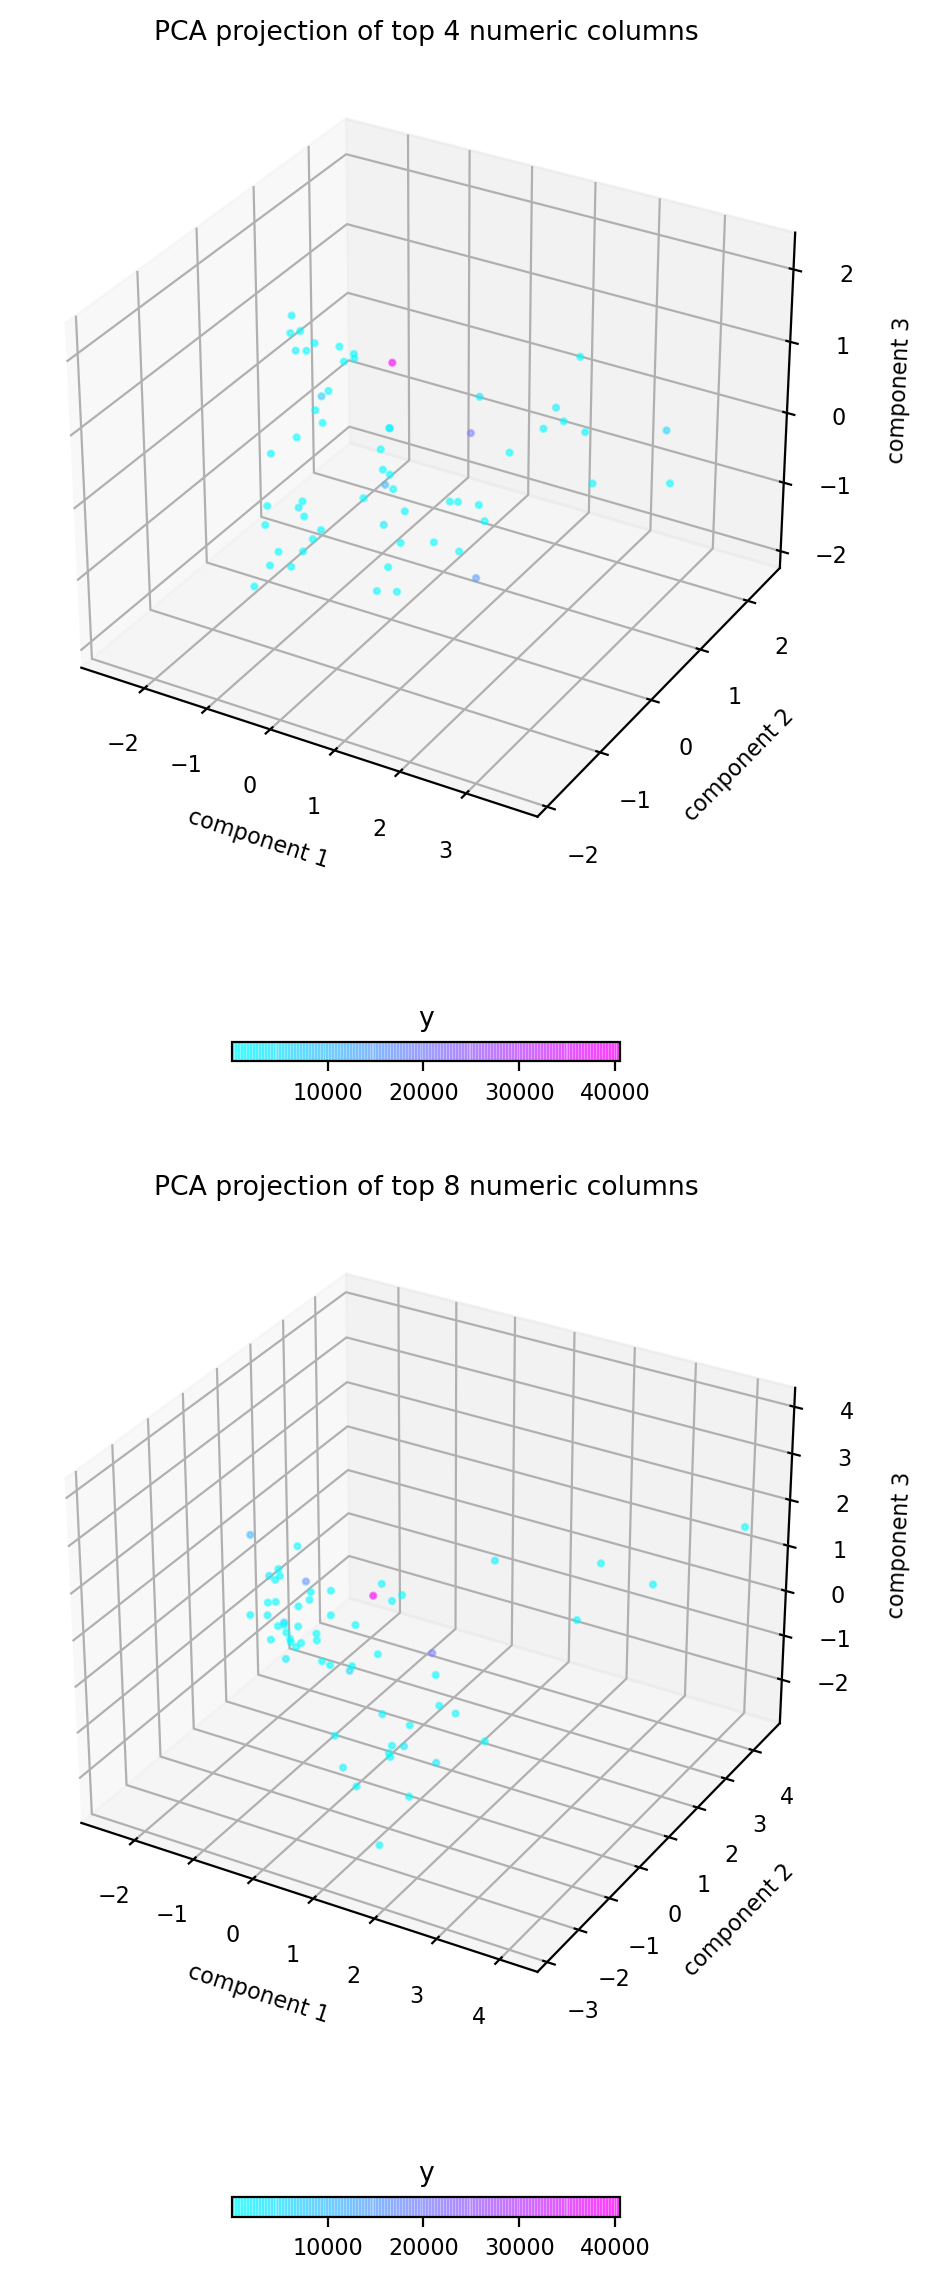

In [10]:
vbs.viewComponents(num_cols=[4,8],keep_cats=False)

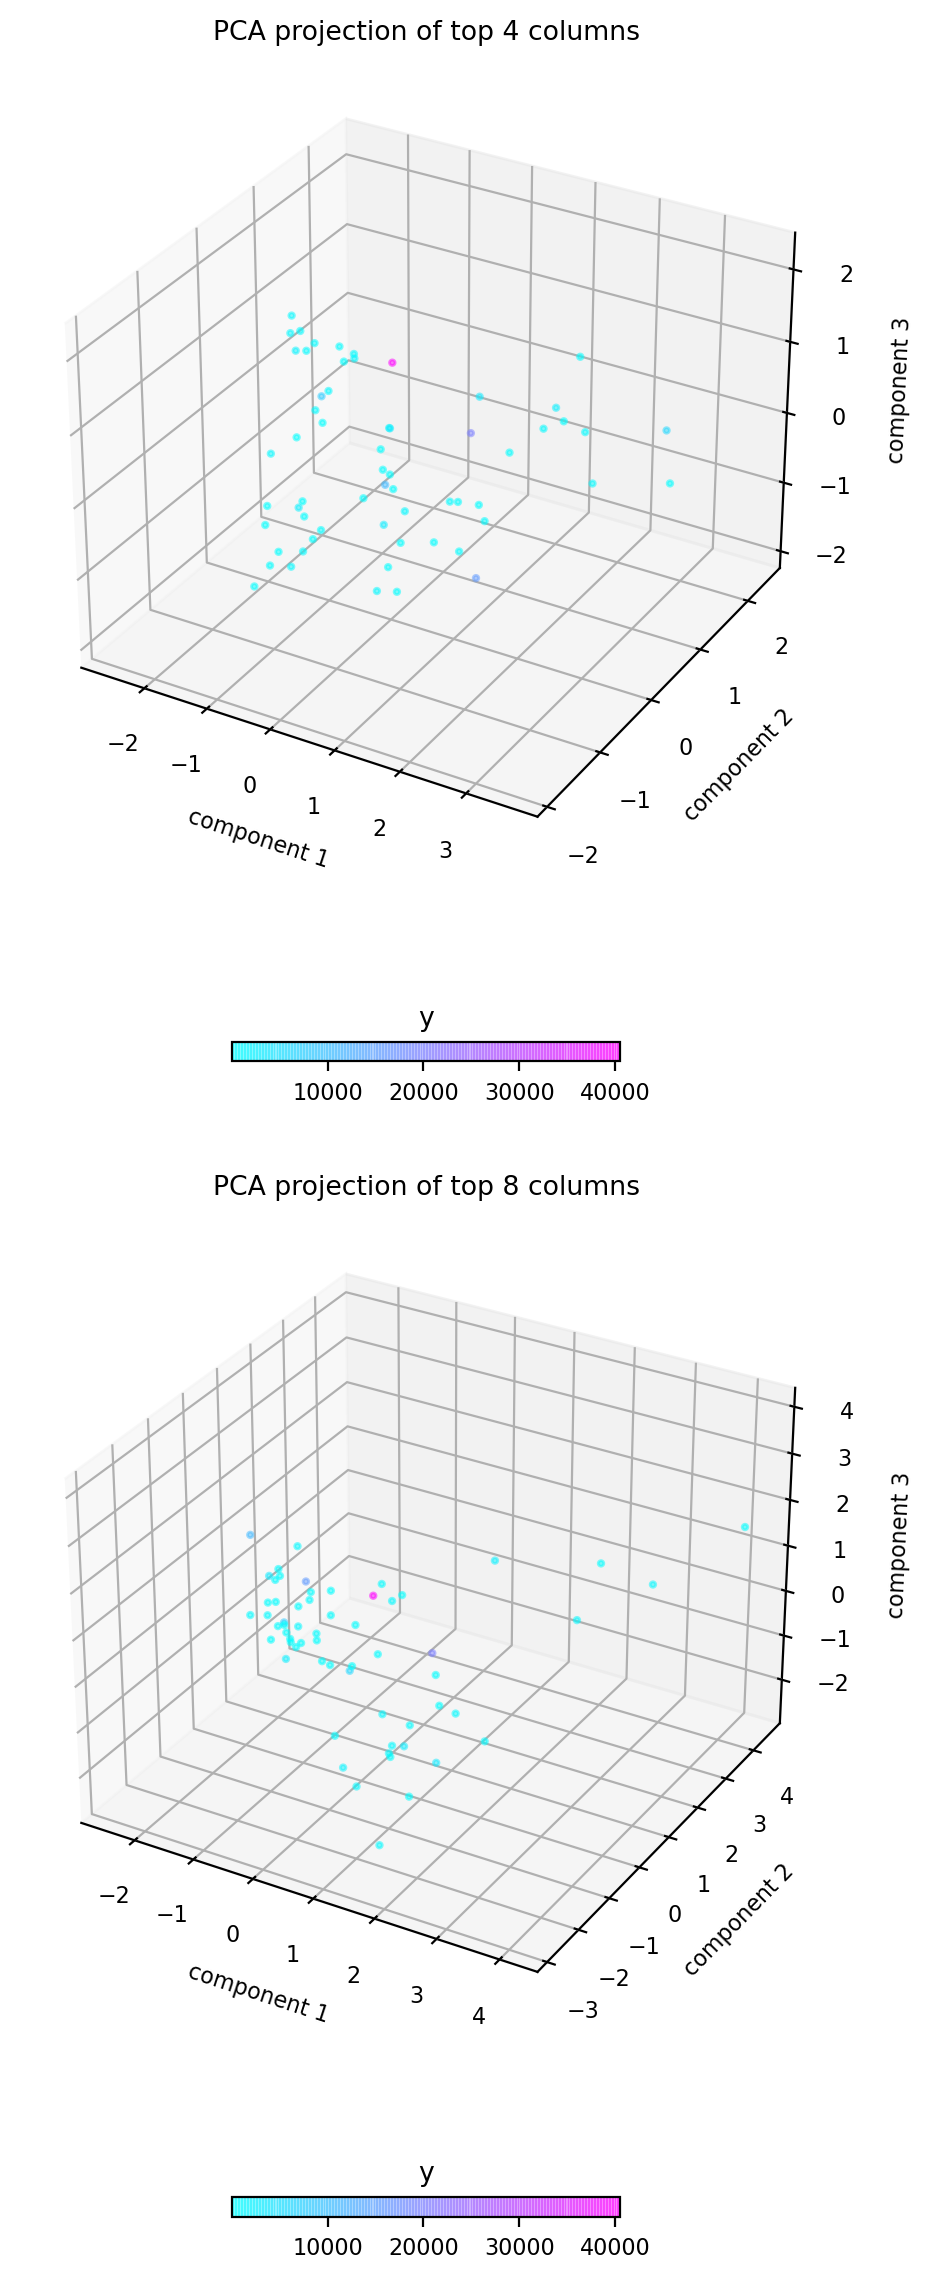

In [11]:
vbs.viewComponents(num_cols=[4,8],keep_cats=True)

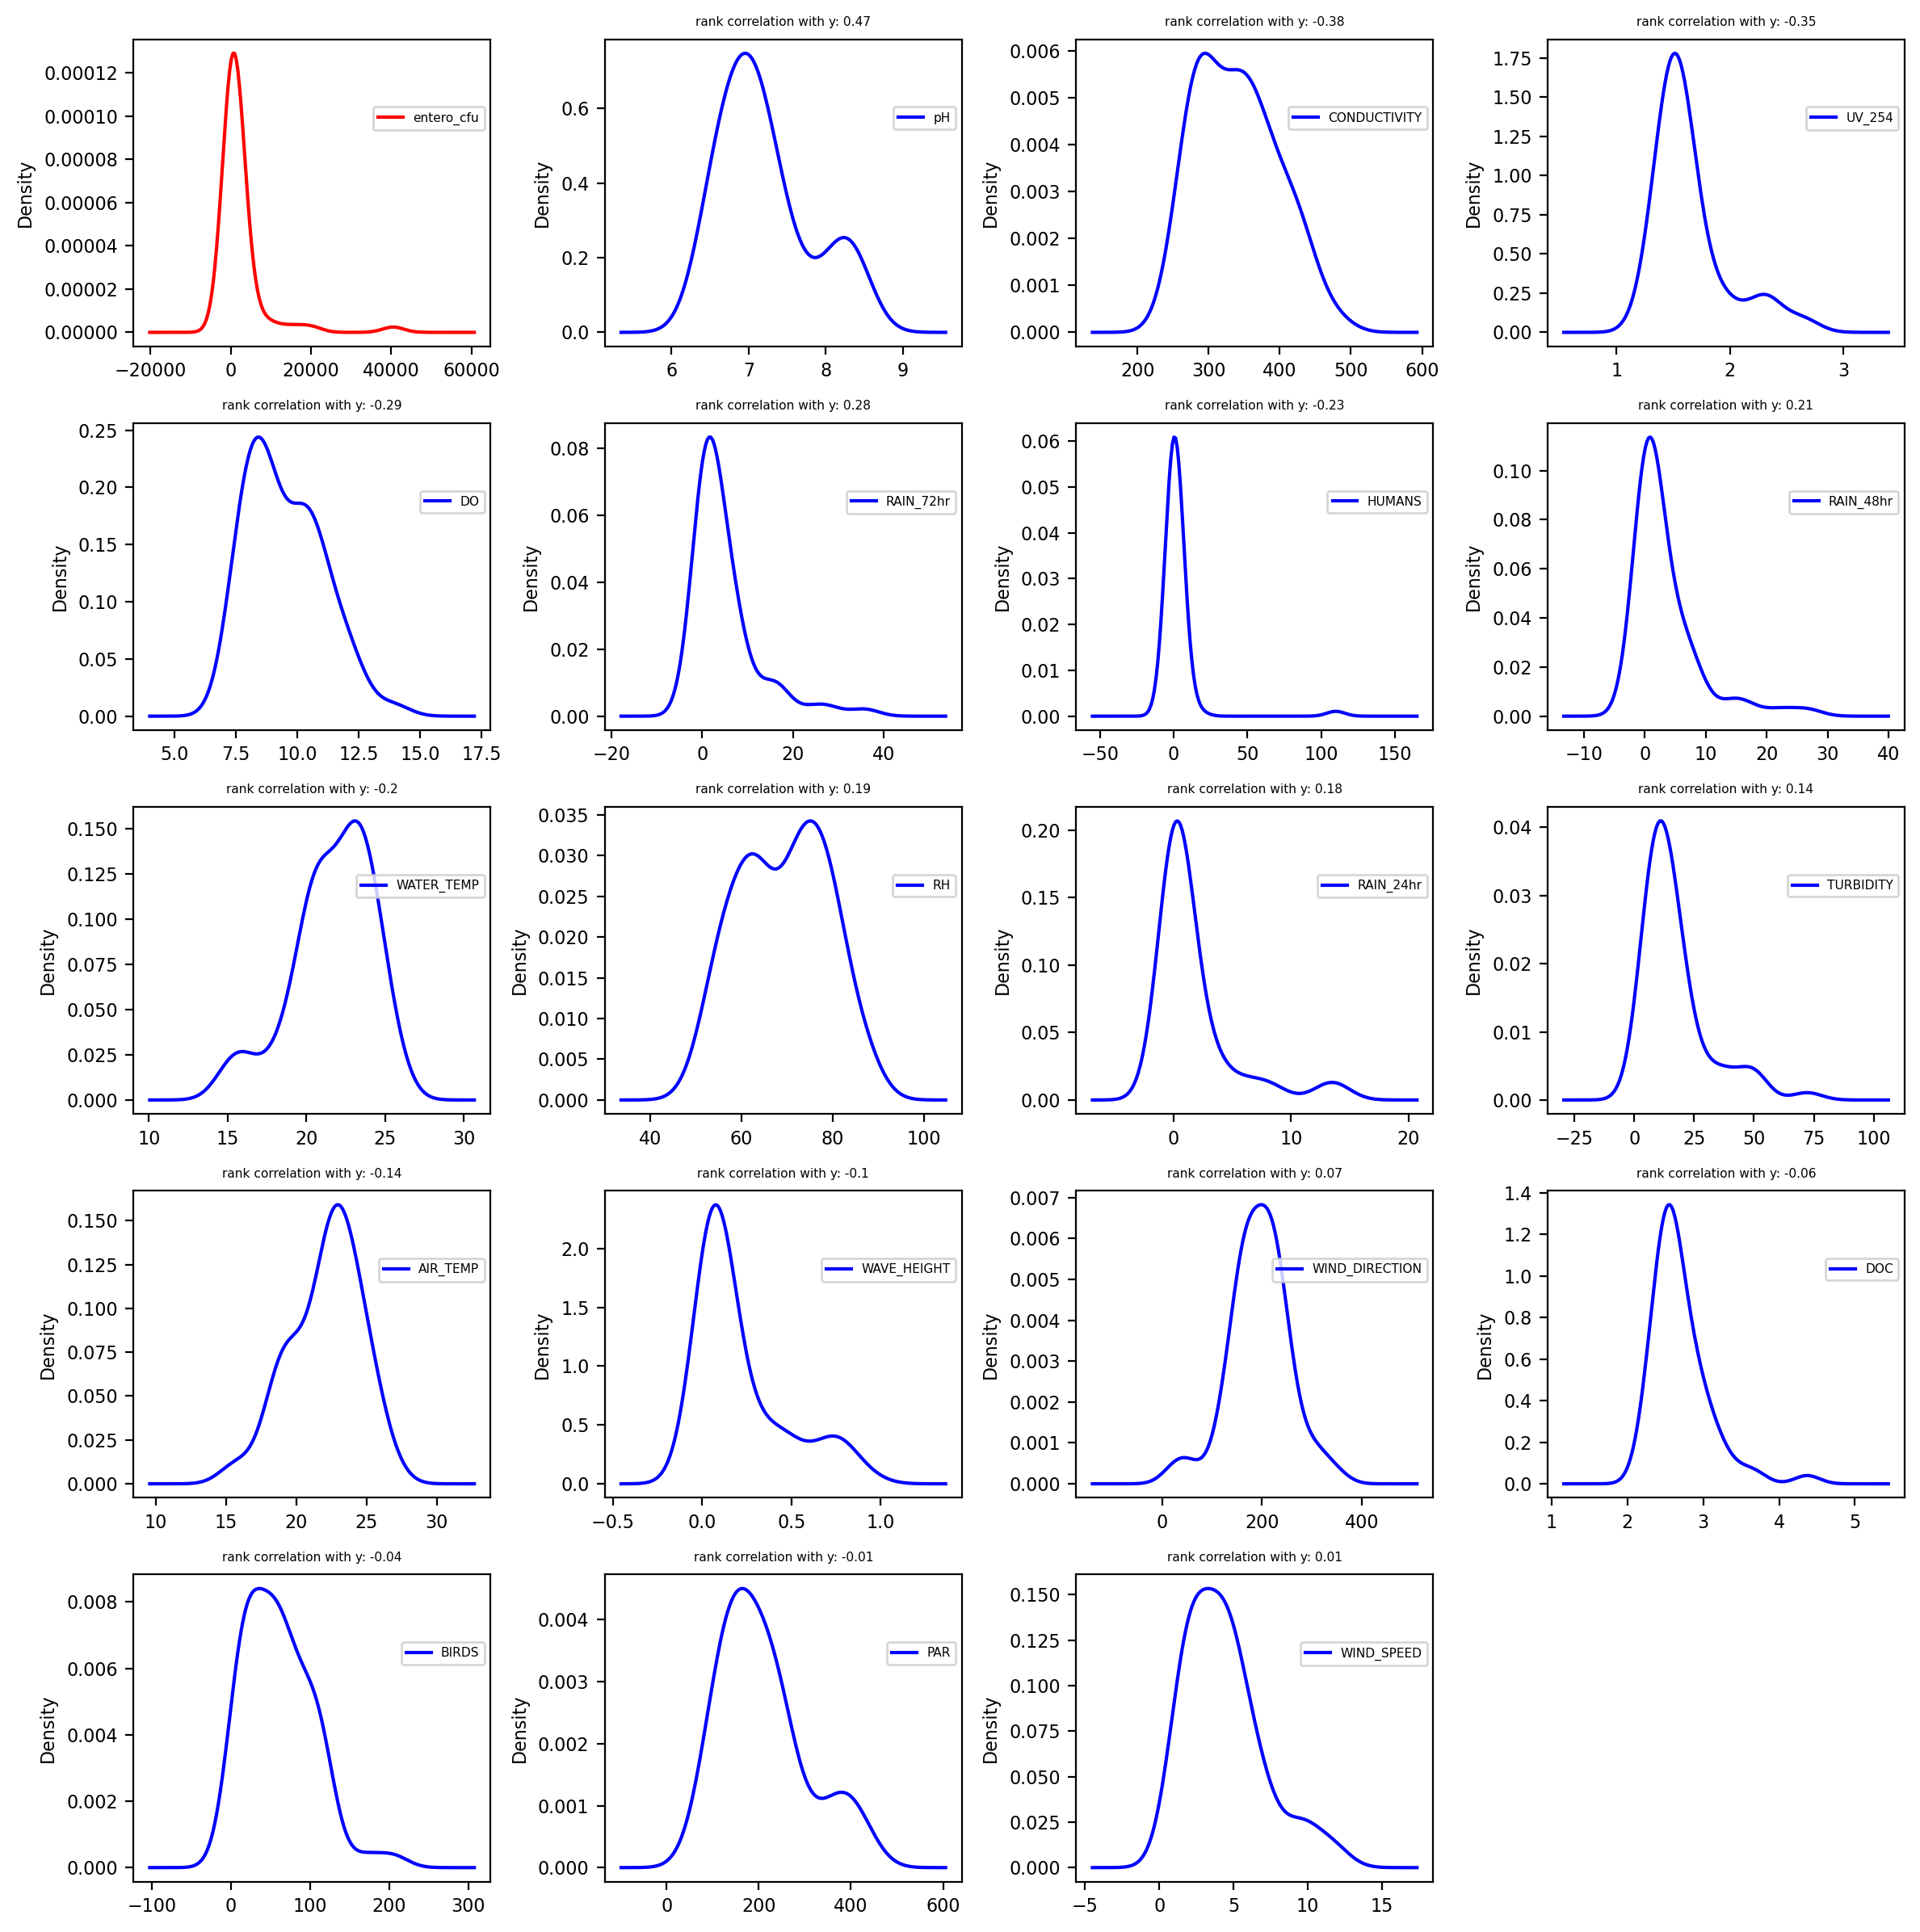

In [12]:
vbs.kernelDensityPie()

In [13]:
#vbs.hierarchicalDendrogram(linkage='ward',dist='pearsonr')

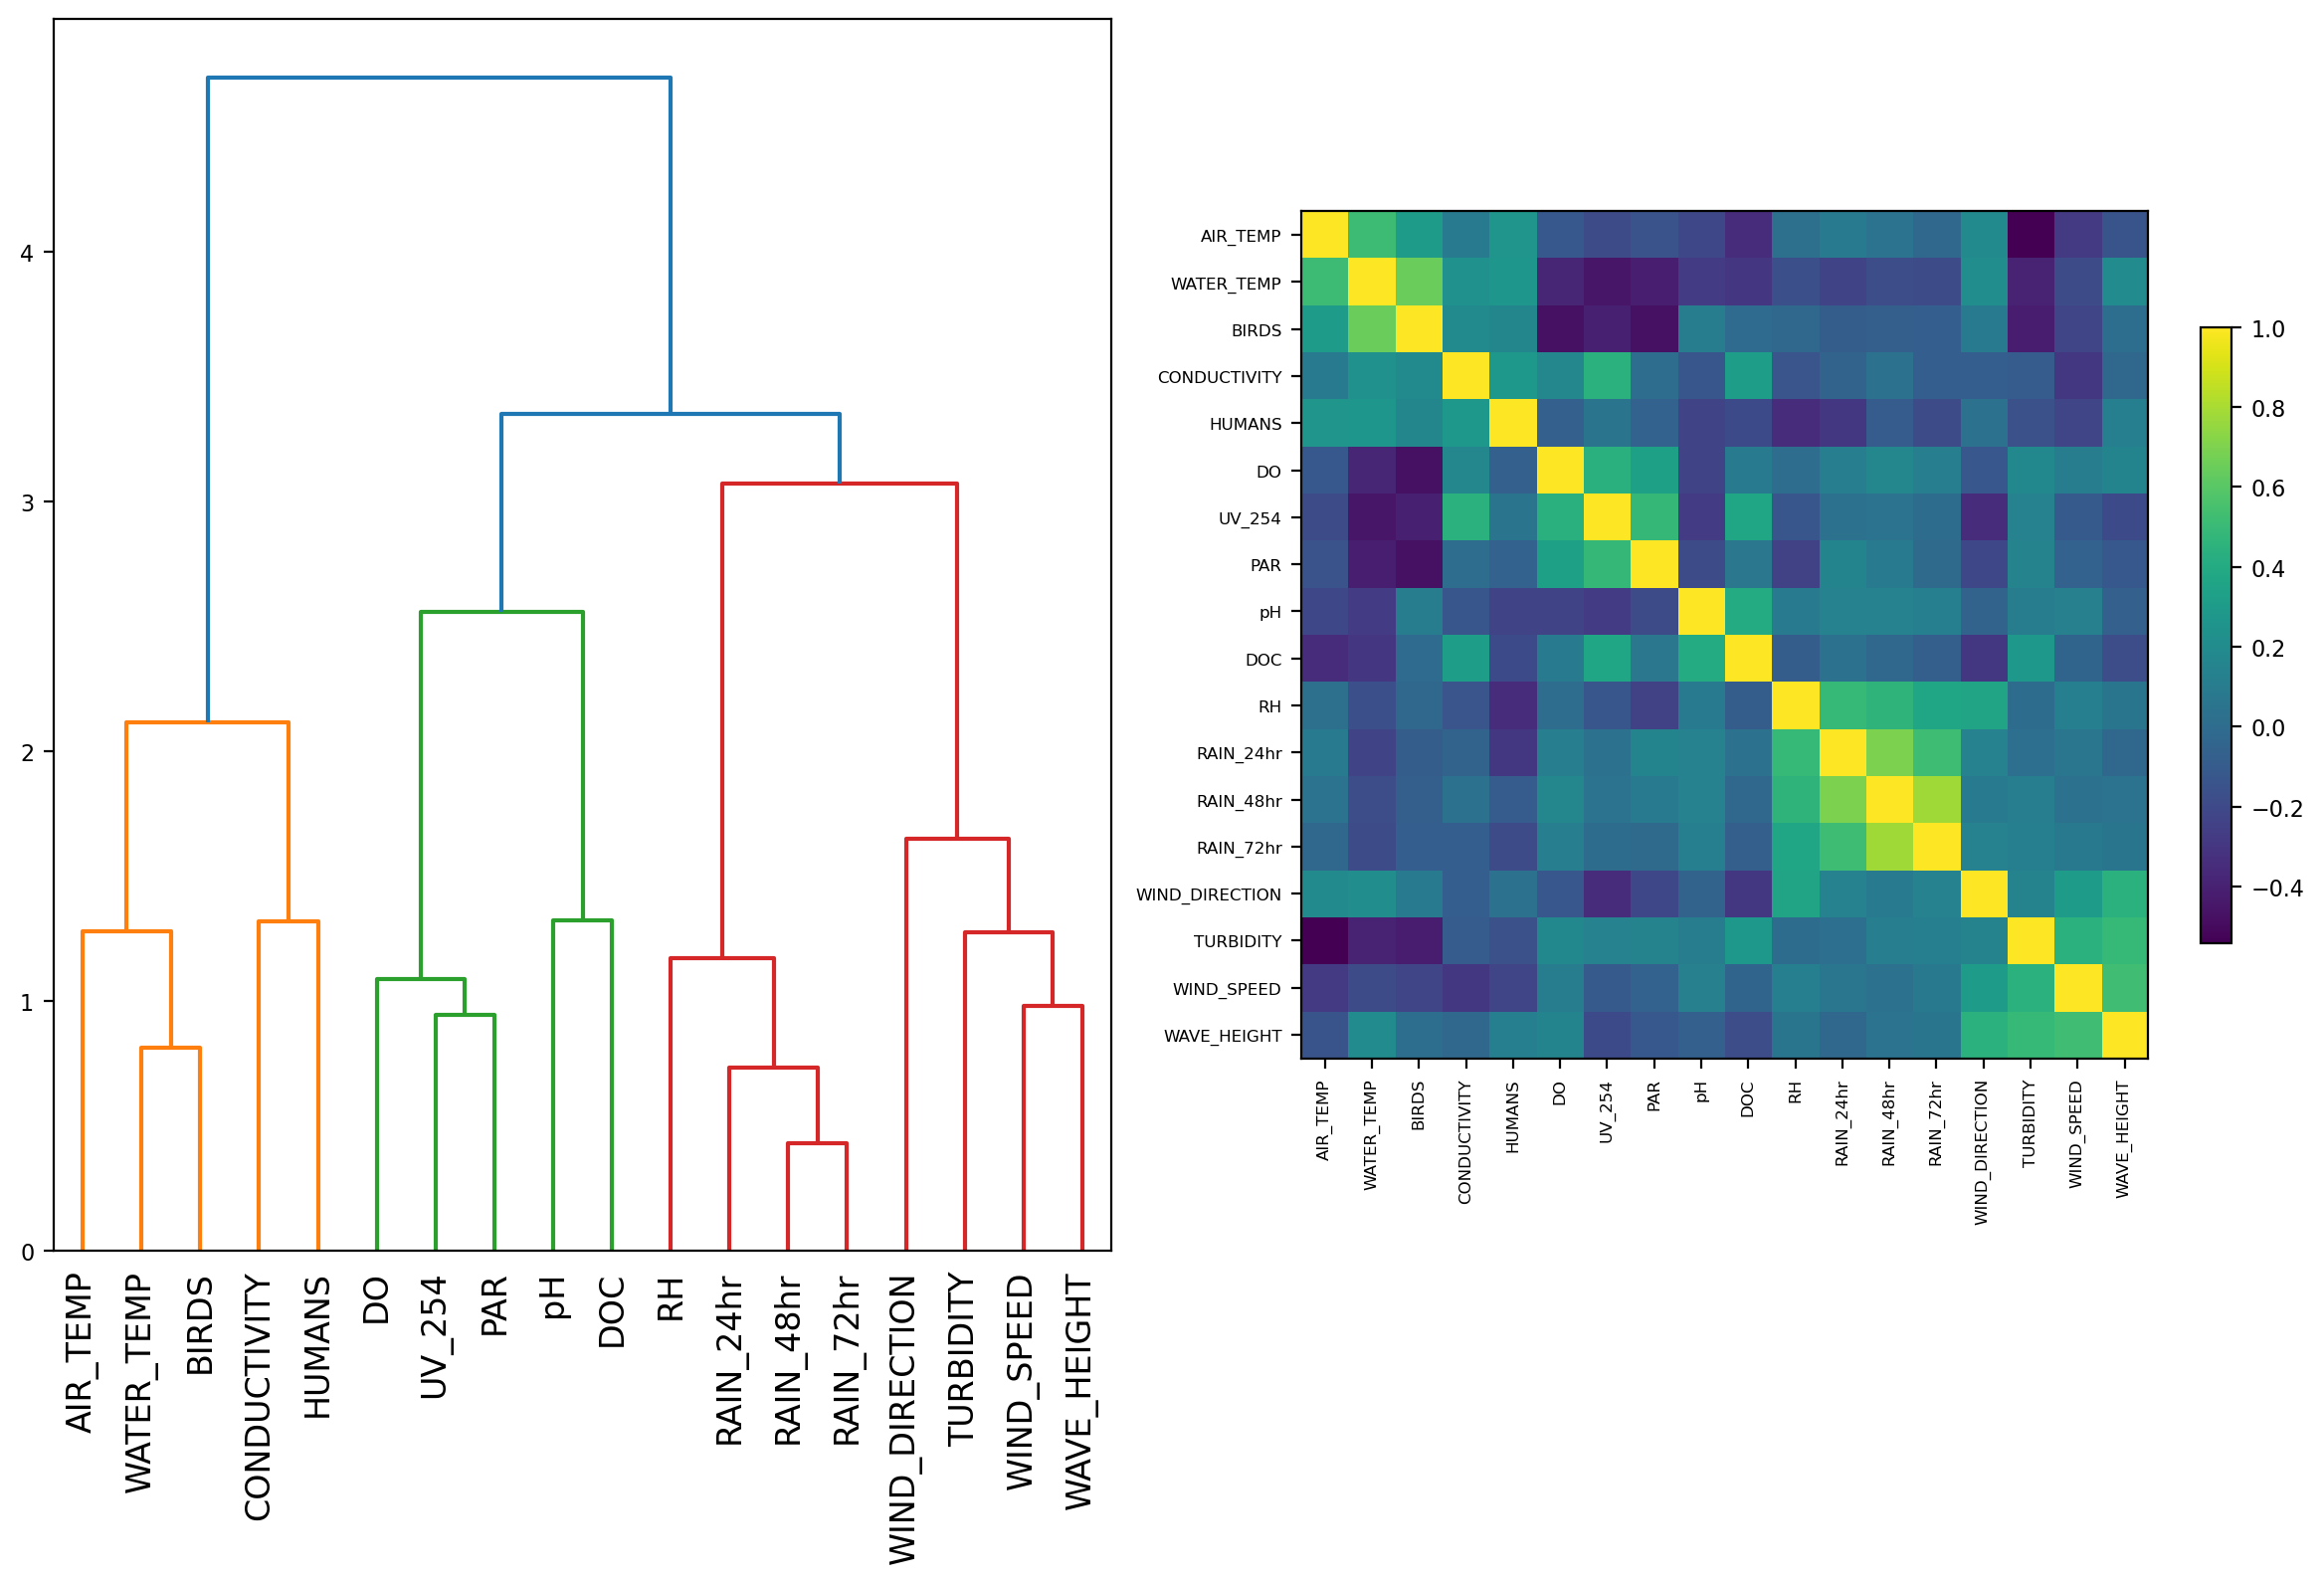

In [14]:
vbs.hierarchicalDendrogram(linkage='ward',dist='spearmanr')

In [15]:
inner_cv_dict={
    'cv_reps':1,
    'cv_folds':5,
    'cv_strategy':('quantile',5)} # ensure each fold has y values from each quantile
inner_cv=vbhelper.getCV(cv_dict=inner_cv_dict)

##### specify data preparation

In [16]:
prep_dict={
    'cat_approach':'together', # imputation is over all variables after one-hot-encoding
    'impute_strategy':'IterativeImputer', # python implementation of MICE: Multivariate Imputation by Chained Equations in R”
    'cat_idx':vbhelper.cat_idx # keep track of the categorical variables
    }
pipe_dict={} # the pipeline setup will go here

#### specify pipelines

###### setup keyword arguments for pipelines

In [17]:
pipe_kwargs={
    'do_prep':not vbhelper.run_stacked, # the stacking regressor will do imputation if run_stacked==False
    'prep_dict':prep_dict,
    'inner_cv':inner_cv,
    'cat_idx':vbhelper.cat_idx,
    'float_idx':vbhelper.float_idx,
    'bestT':False # if true, test each covariate for optimal transformation 
    }

##### add a gradient boosting regressor pipeline

In [18]:
from vb_estimators import GBR

gbr_kwargs=pipe_kwargs.copy()
gbr_kwargs['est_kwargs']={
    'n_estimators':[64,128],
    'max_depth':[2,3]
    }
pipe_dict['gbr']={
    'pipe':GBR,
    'pipe_kwargs':gbr_kwargs
    }

##### create a cross-validated lasso linear regression pipeline

In [19]:
from vb_estimators import  L1Lars

l1_kwargs=pipe_kwargs.copy()
l1_kwargs['max_n_alphas']=500 # alpha is the only hyper-parameter
pipe_dict['lassolars']={
    'pipe':L1Lars,
    'pipe_kwargs':l1_kwargs
    }

##### and a support vector machine regressor using the rbf kernel

In [20]:
from vb_estimators import RBFSVR

rbf_kwargs=pipe_kwargs.copy()
rbf_kwargs['gridpoints']=5 
pipe_dict['rbfSVR']={
    'pipe':RBFSVR,
    'pipe_kwargs':rbf_kwargs
    }

and finally add a pipeline that tests a few non-linear models

In [21]:
from vb_estimators import FlexiblePipe

nl_pipe_kwargs=pipe_kwargs.copy()
nl_pipe_kwargs['functional_form_search']=True
nl_pipe_kwargs['flex_kwargs']={'robust':True}
pipe_dict['nonlinear']={
    'pipe':FlexiblePipe,
    'pipe_kwargs':nl_pipe_kwargs
}

In [22]:
#and load the pipelines
vbhelper.setPipeDict(pipe_dict)
vbhelper.setModelDict()

In [23]:
vbhelper.runCrossValidate(try_load=True)

jhash:  44d912e5a8a249eb35311e725d067340
stacking_reg,[('neg_mean_squared_error', -inf), ('neg_mean_absolute_error', -1.5559229890621432e+255), ('r2', -inf)], runtime:6.670336135228475 min.


In [24]:
vbhelper.buildCVScoreDict()
vbhelper.saveCVResults()

cross validation results saved to project_cv_results.json


### Plot the results

In [25]:
from vb_plotter import VBPlotter
plotter=VBPlotter()

with open('project_cv_results.json','rb') as f:
    cv_results_and_scores=json.load(f)
plotter.setData(cv_results_and_scores)

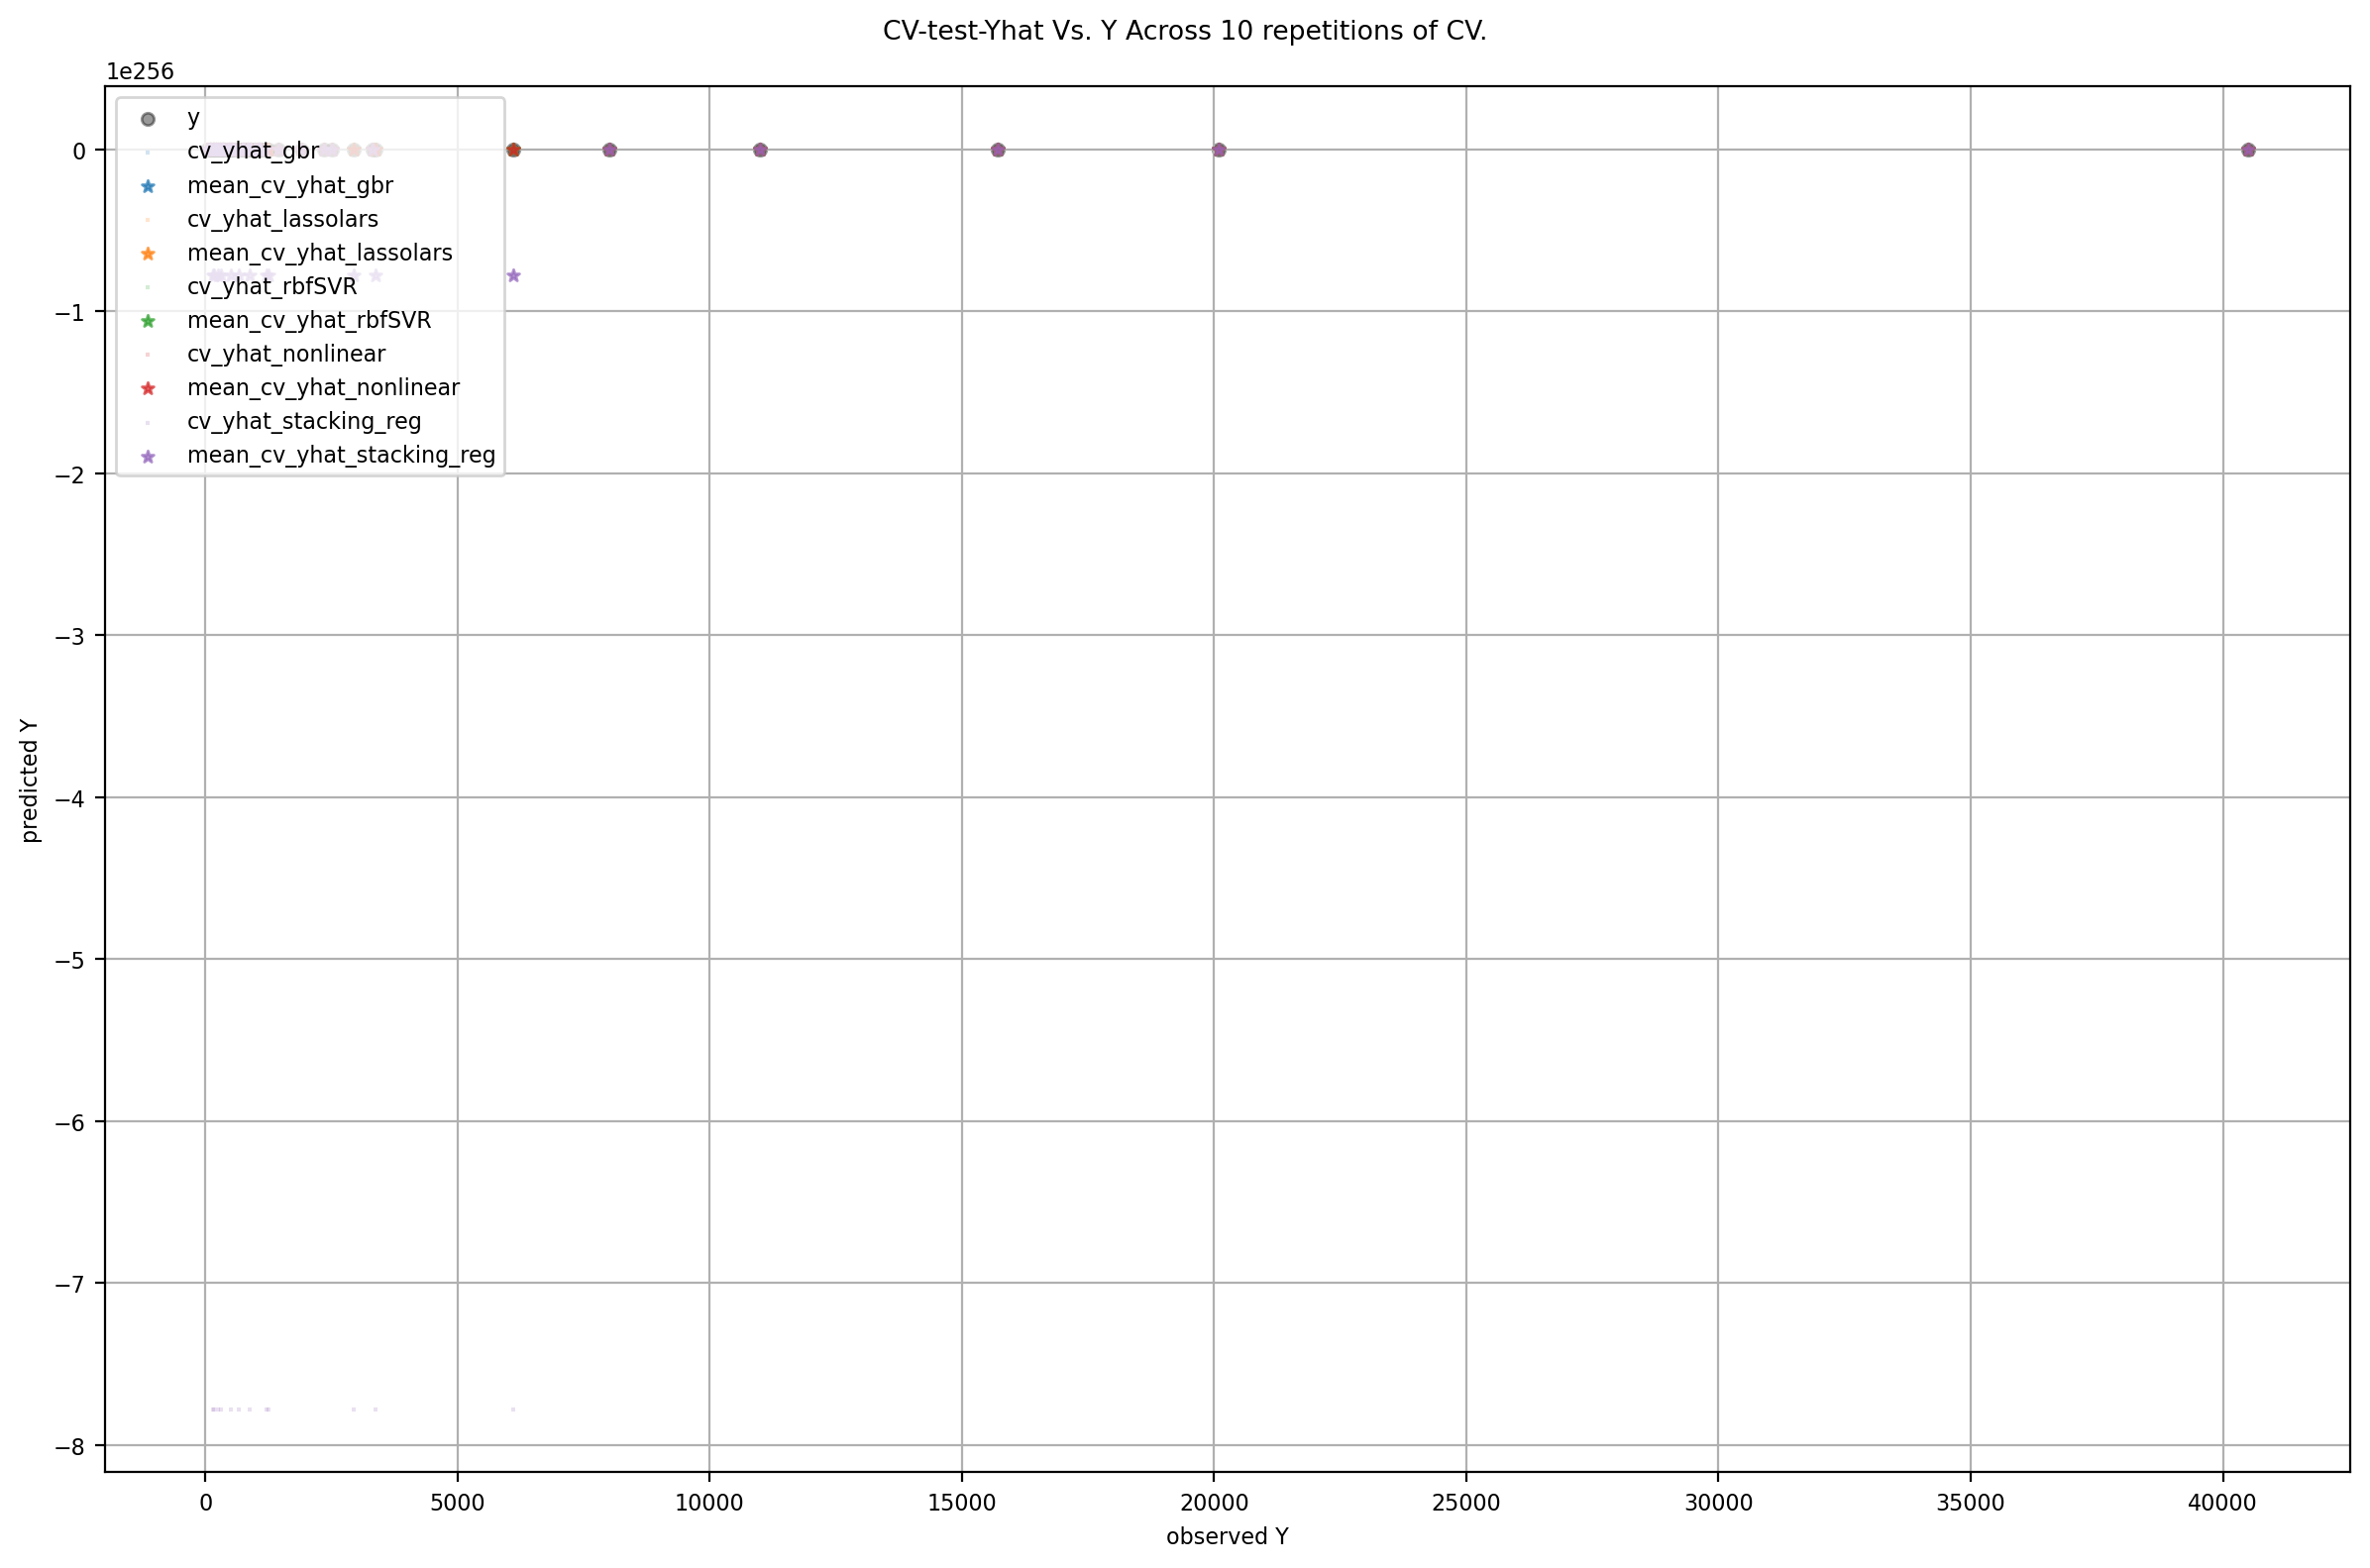

In [26]:
plotter.plotCVYhatVsY(single_plot=True,include_all_cv=True)

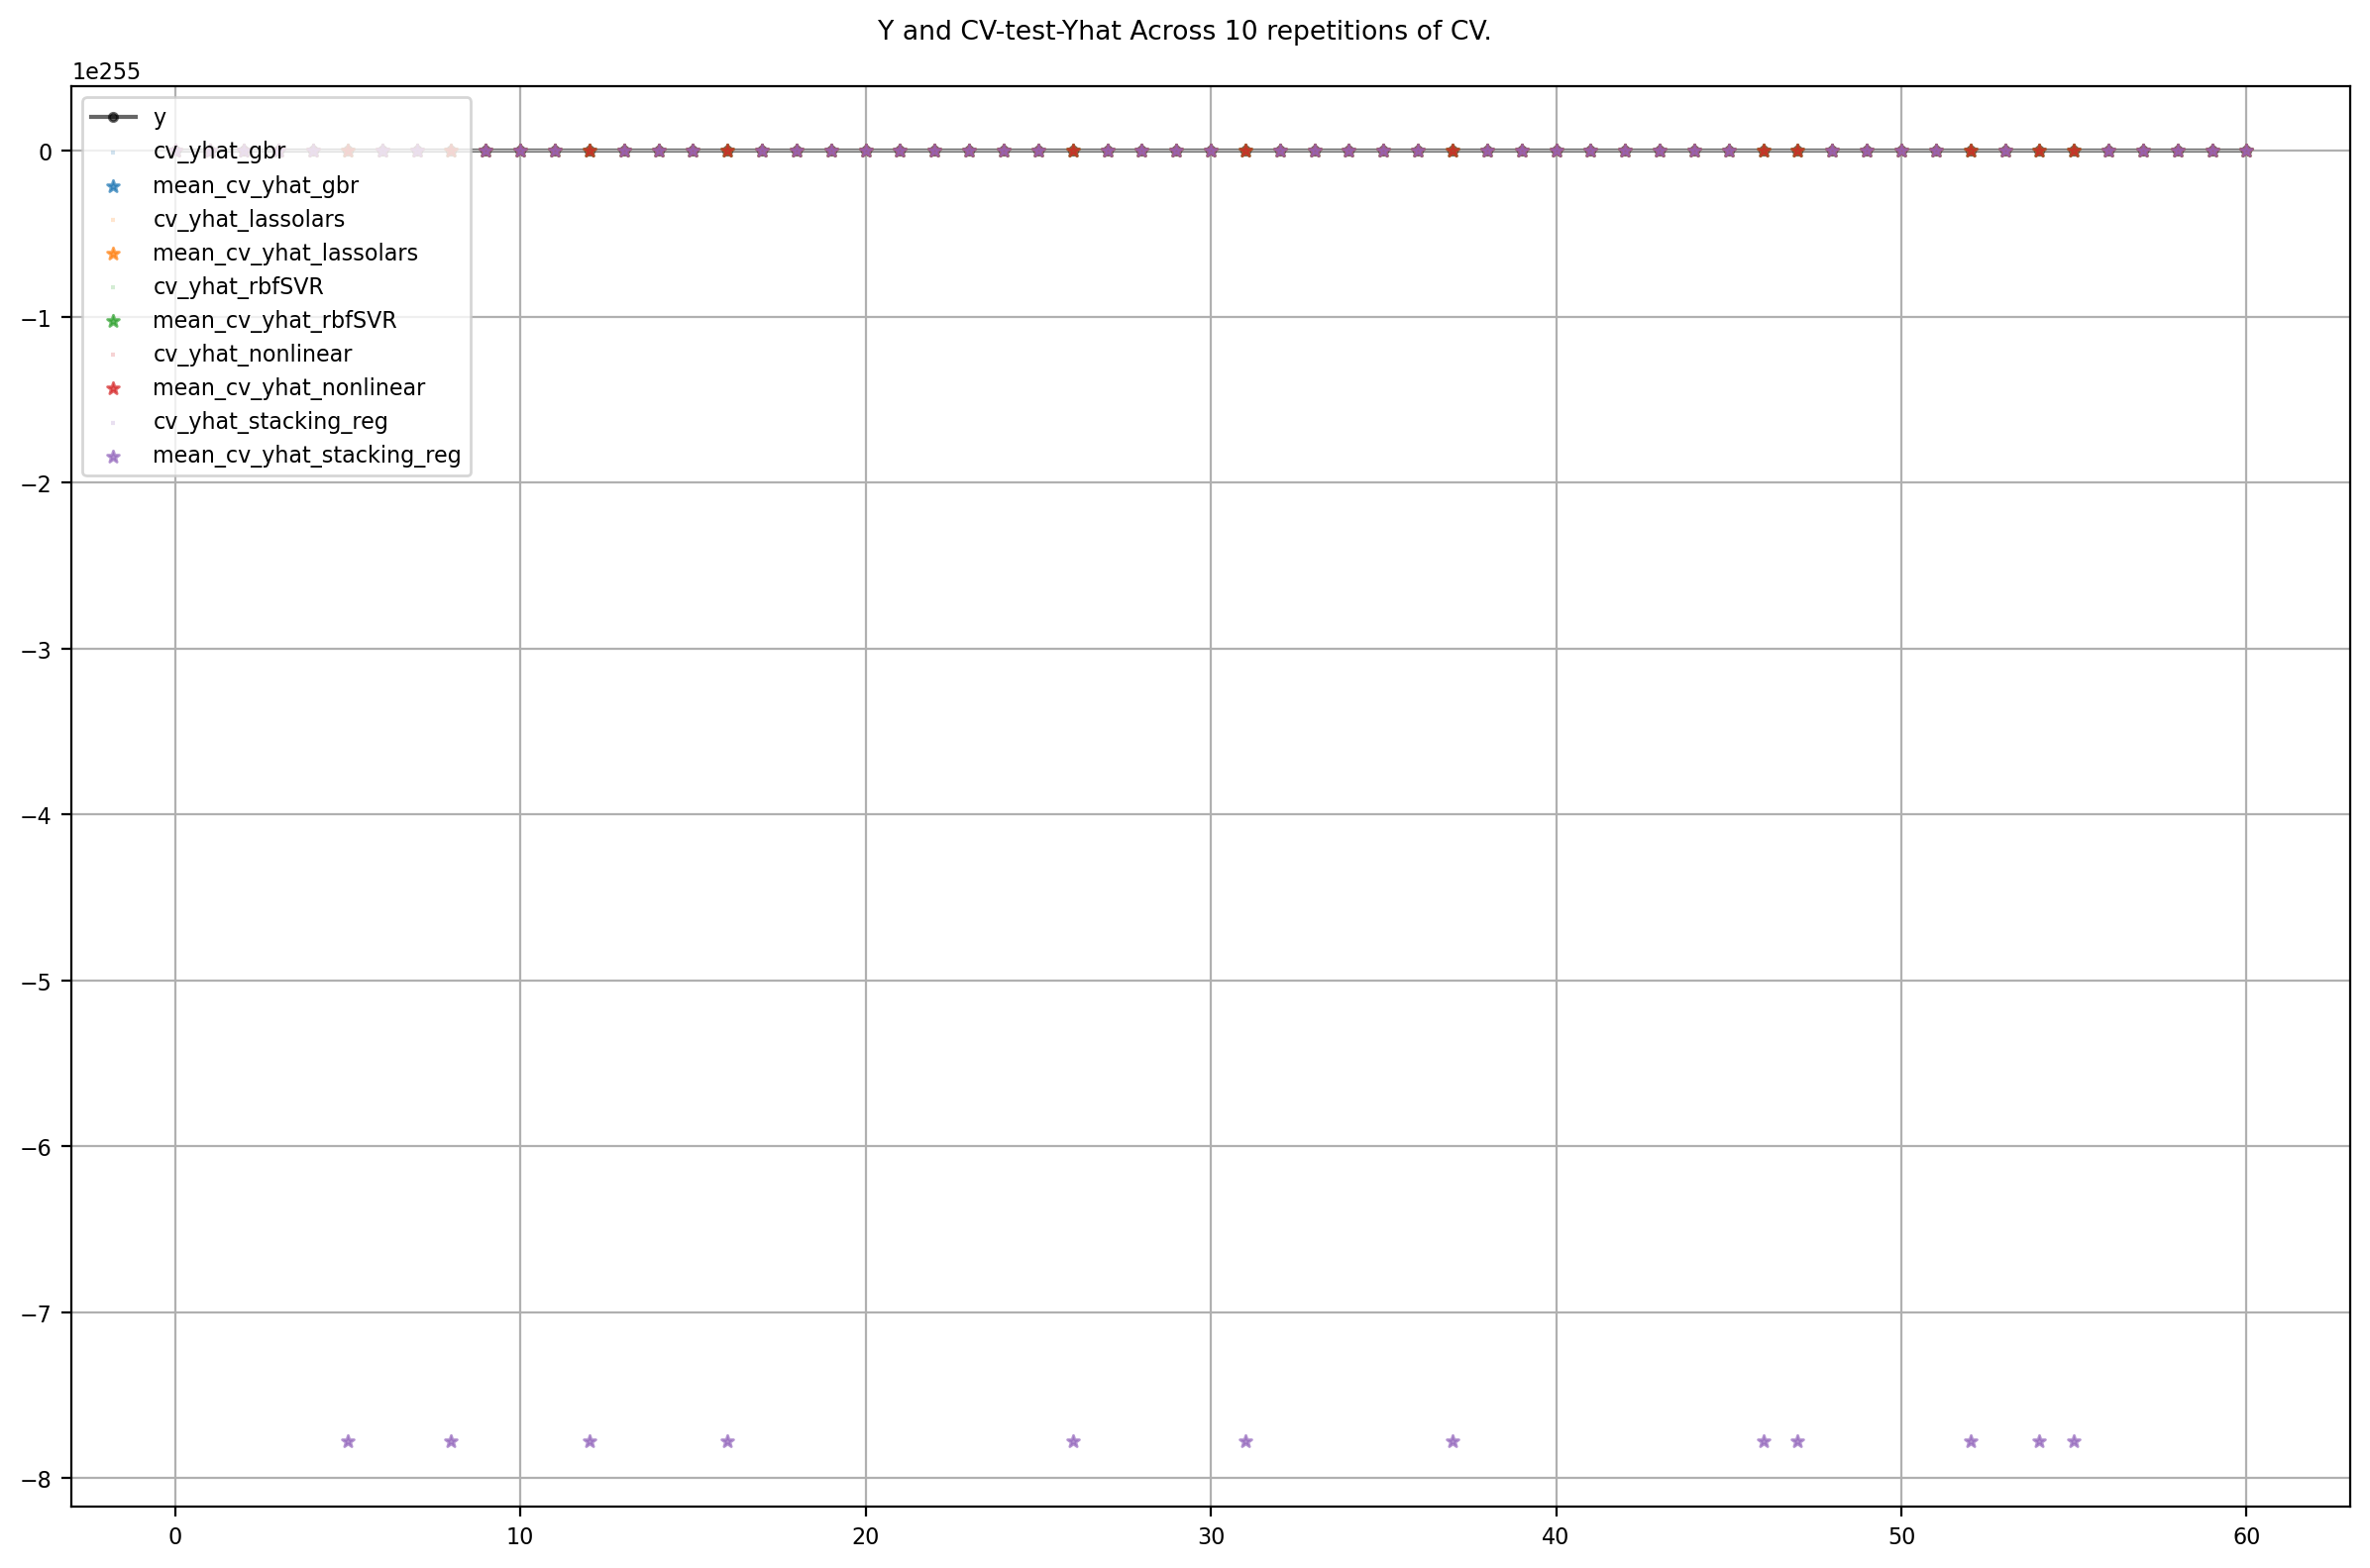

In [27]:
plotter.plotCVYhat(single_plot=True,include_all_cv=True) #add option to use original row order instead of sort

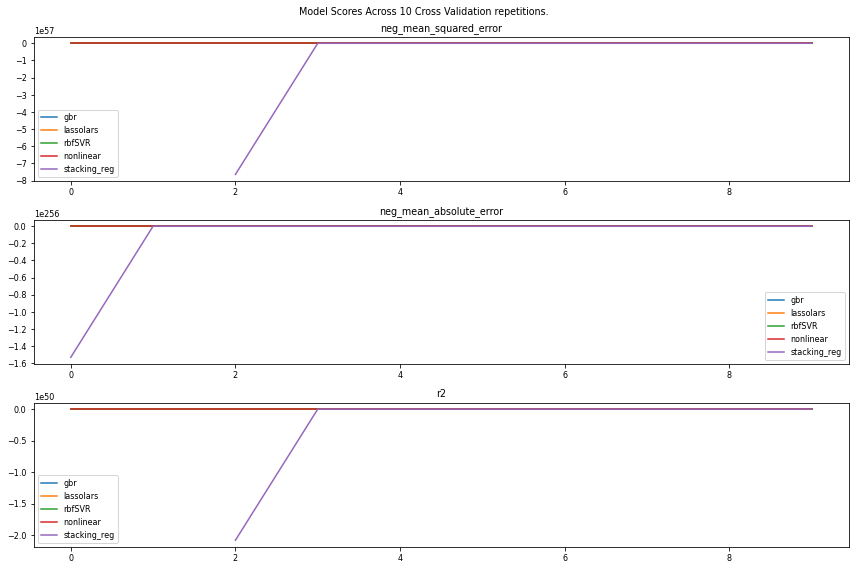

In [28]:
plotter.plotCVScores(sort=1)

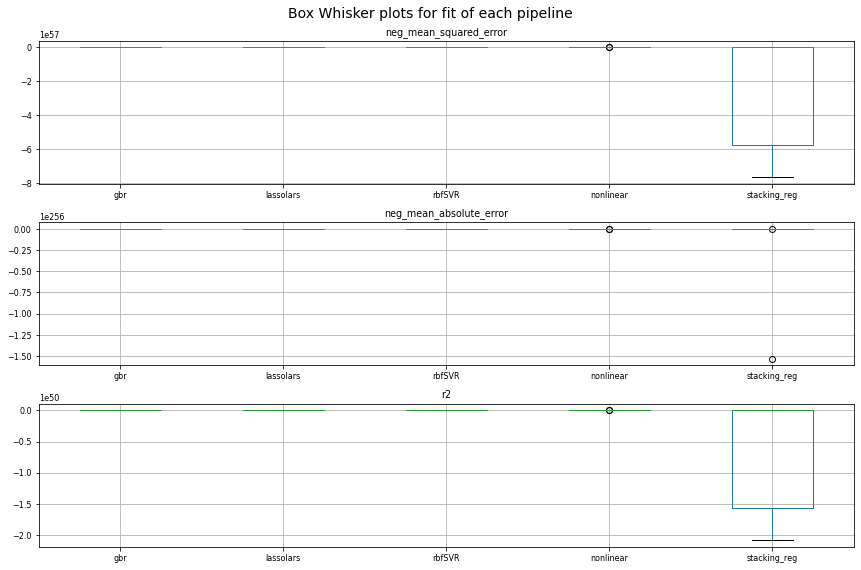

In [29]:
plotter.plotBoxWhiskerCVScores()

# VB web
## Small Data Procedure
---
**gradient boosting regressor is selected**

#### Task 2: Train the Final, Predictive Model
##### Using all of the data

In [30]:
vbhelper.refitPredictiveModels(selected_models=['gbr'])

# VB web
## Small Data Procedure
### Predict Phase
Finally we are ready to use the predictive model that we just estimated.


In [31]:
vbhelper.predictandSave(X_predict)

prediction results saved to project_prediction_results.json


In [32]:
with open('project_prediction_results.json', 'r') as f:
    project_prediction_results=json.load(f)
plotter.setPredictData(project_prediction_results)

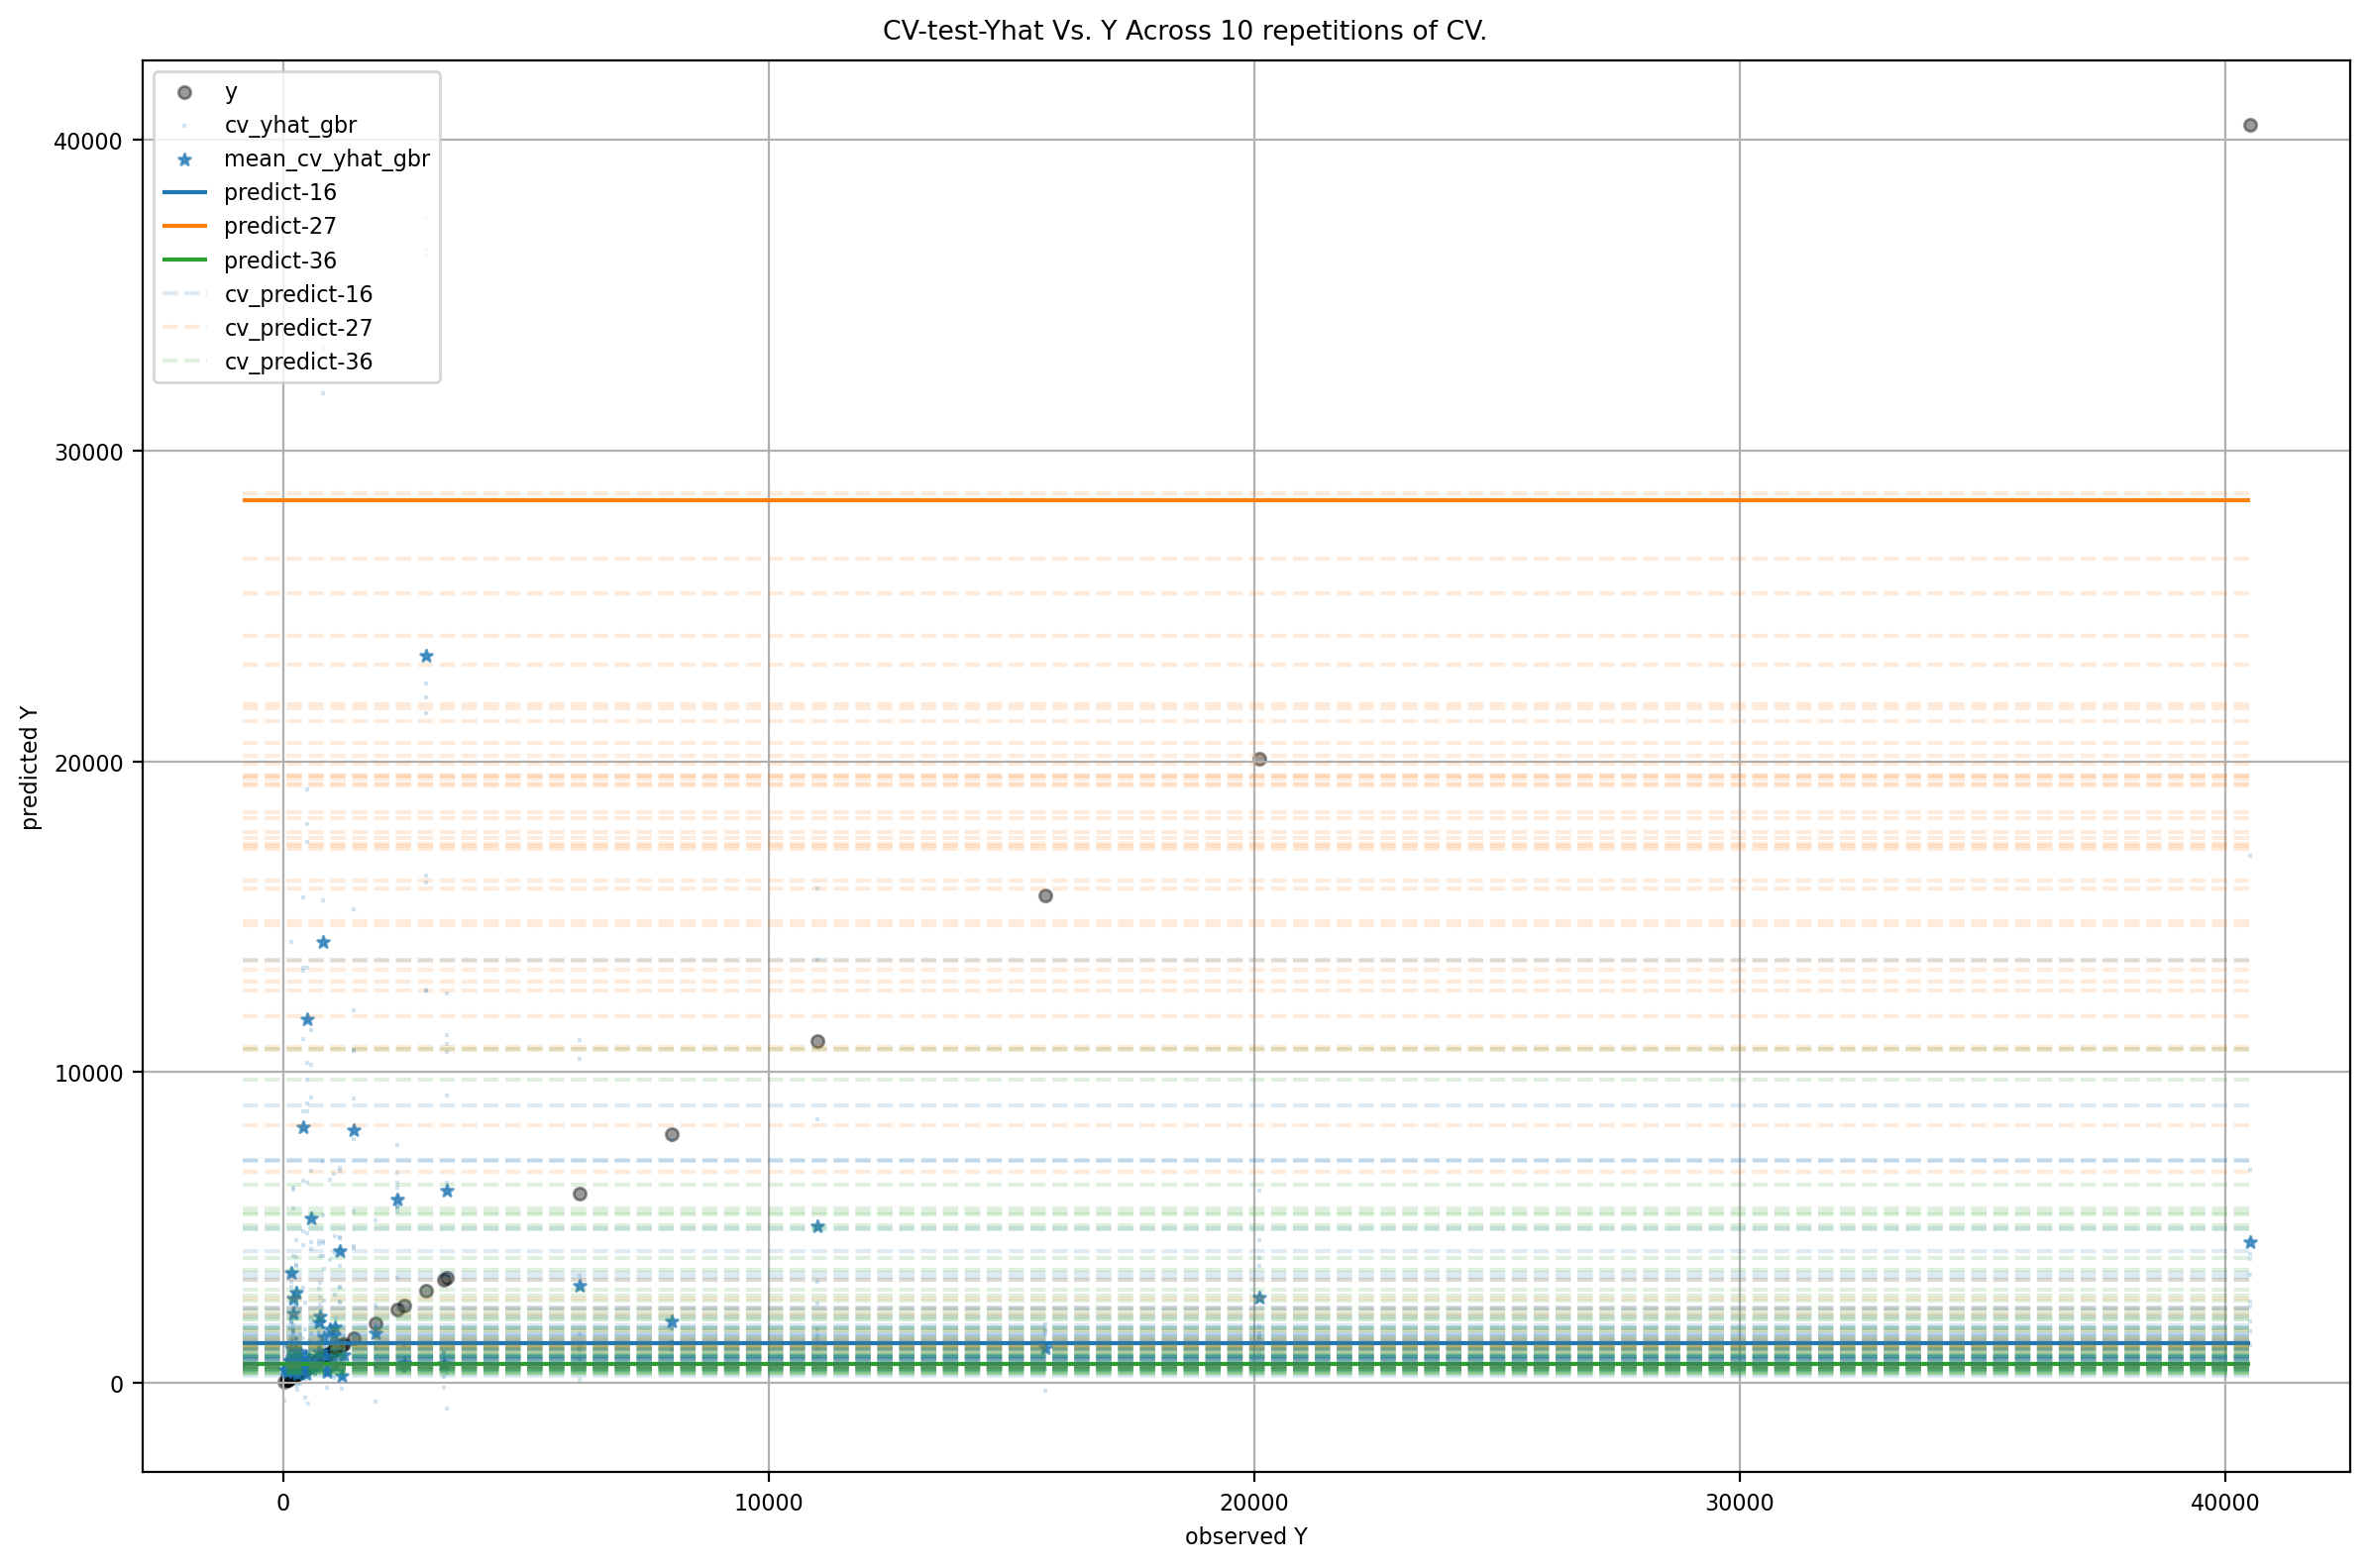

In [33]:
p_kwargs=dict(single_plot=True, include_all_cv=True,
              ypredict=True,cv_ypredict=True,estimators='selected')
plotter.plotCVYhatVsY(**p_kwargs)

#### And redraw the plots with the known values of y as vertical lines

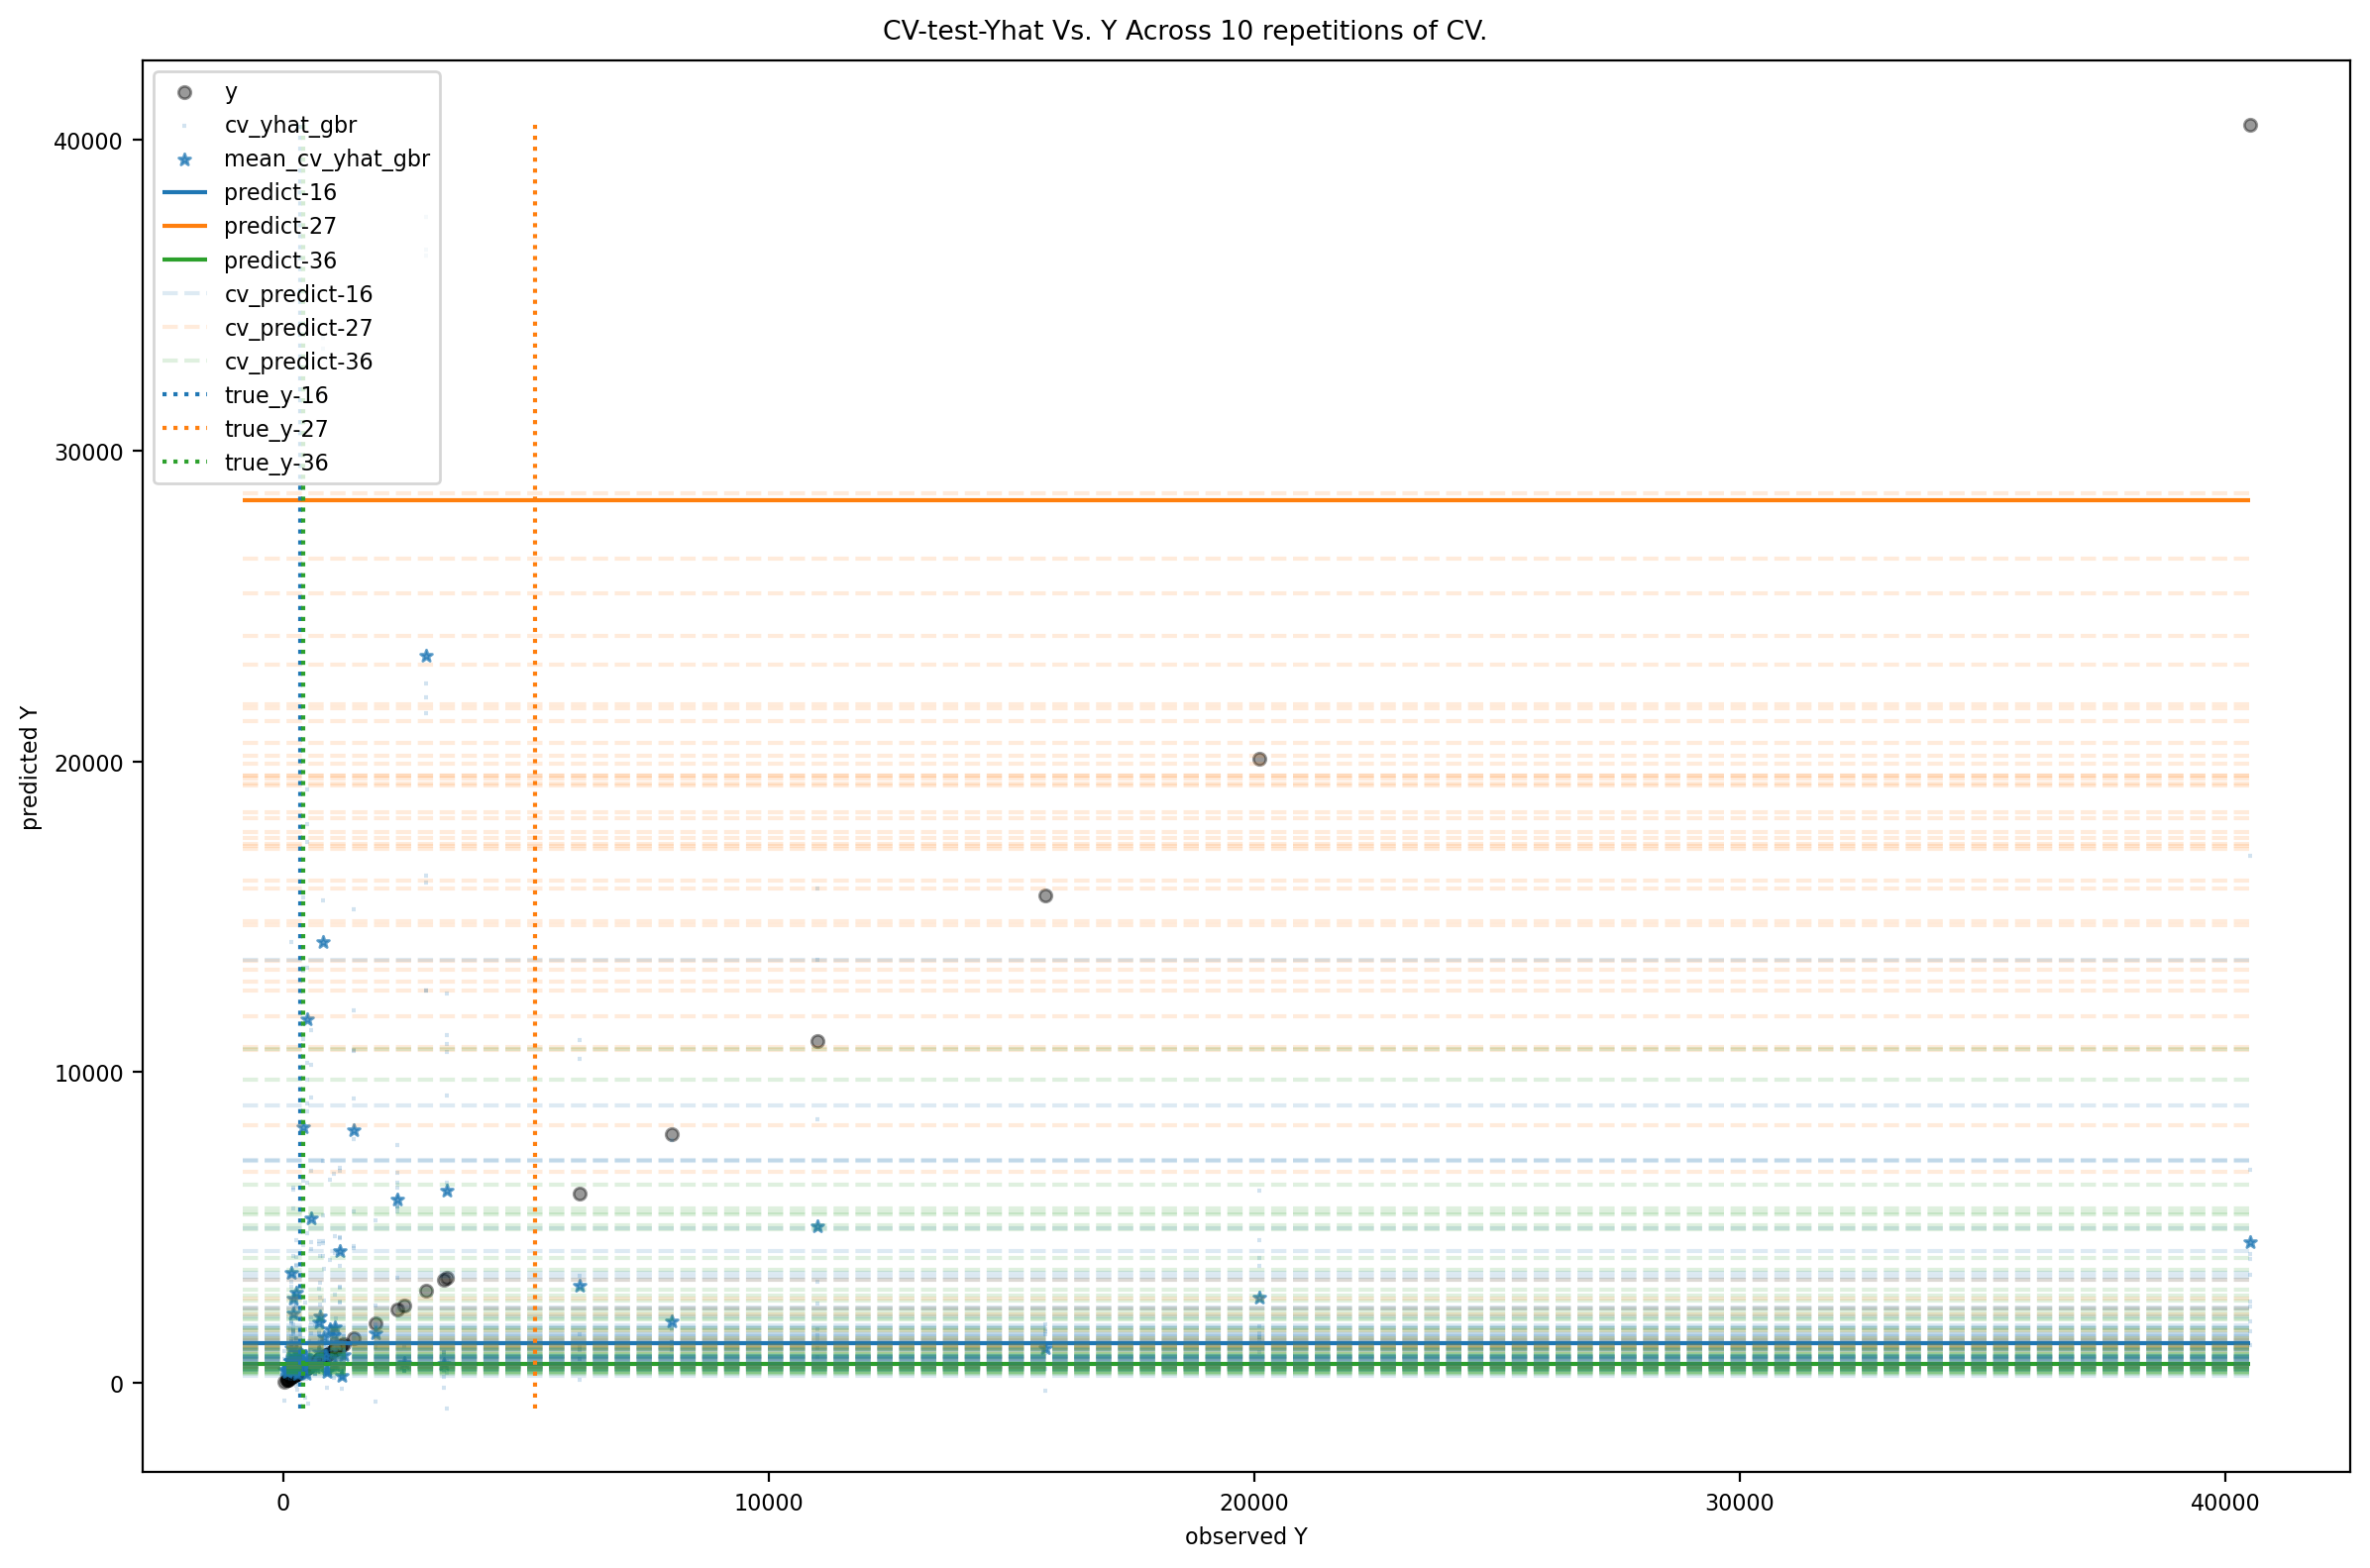

In [34]:
plotter.plotCVYhatVsY(**p_kwargs,true_y=y_predict)

In [35]:
import re

In [36]:
for i,idx in enumerate(plotter.ypredict.index):
    y_idx=''.join(re.split('-',idx)[1:])
    print(f'idx:{idx},y_idx:{y_idx}')
    print(y_idx,y_predict.loc[y_idx])

idx:predict-16,y_idx:16
16 360
idx:predict-27,y_idx:27
27 5200
idx:predict-36,y_idx:36
36 420


#### Or we can predict each observation separately

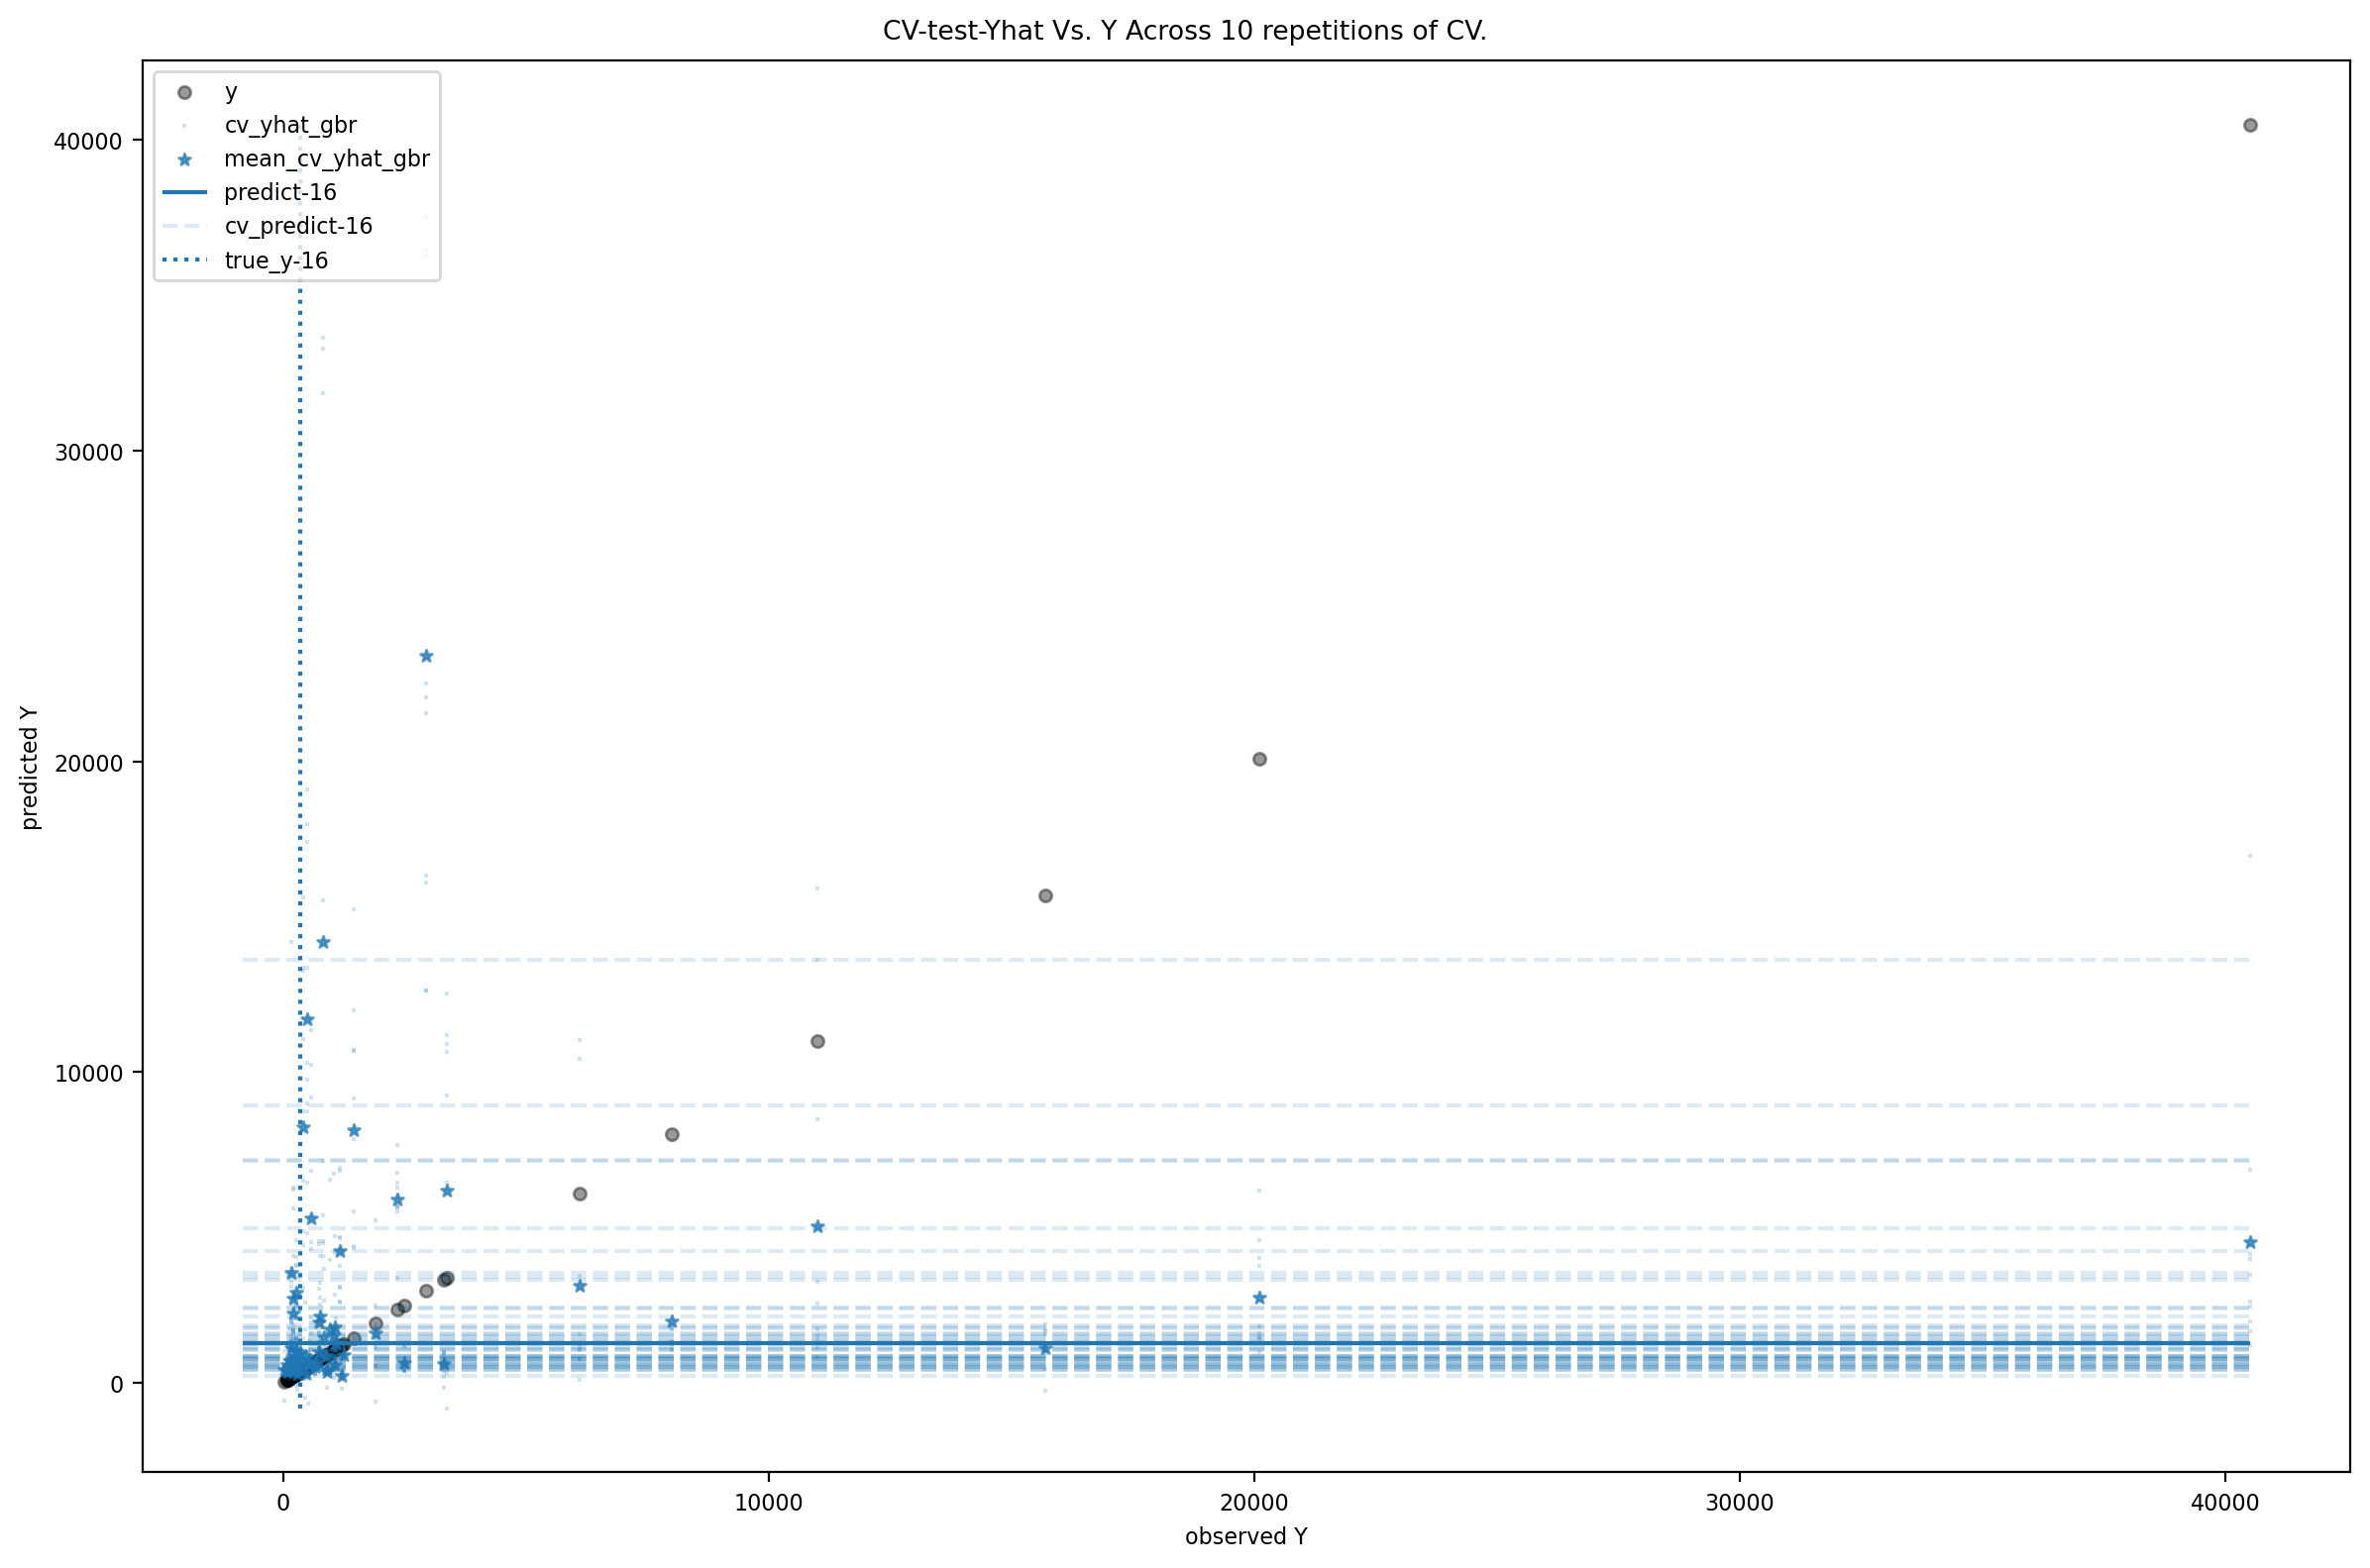

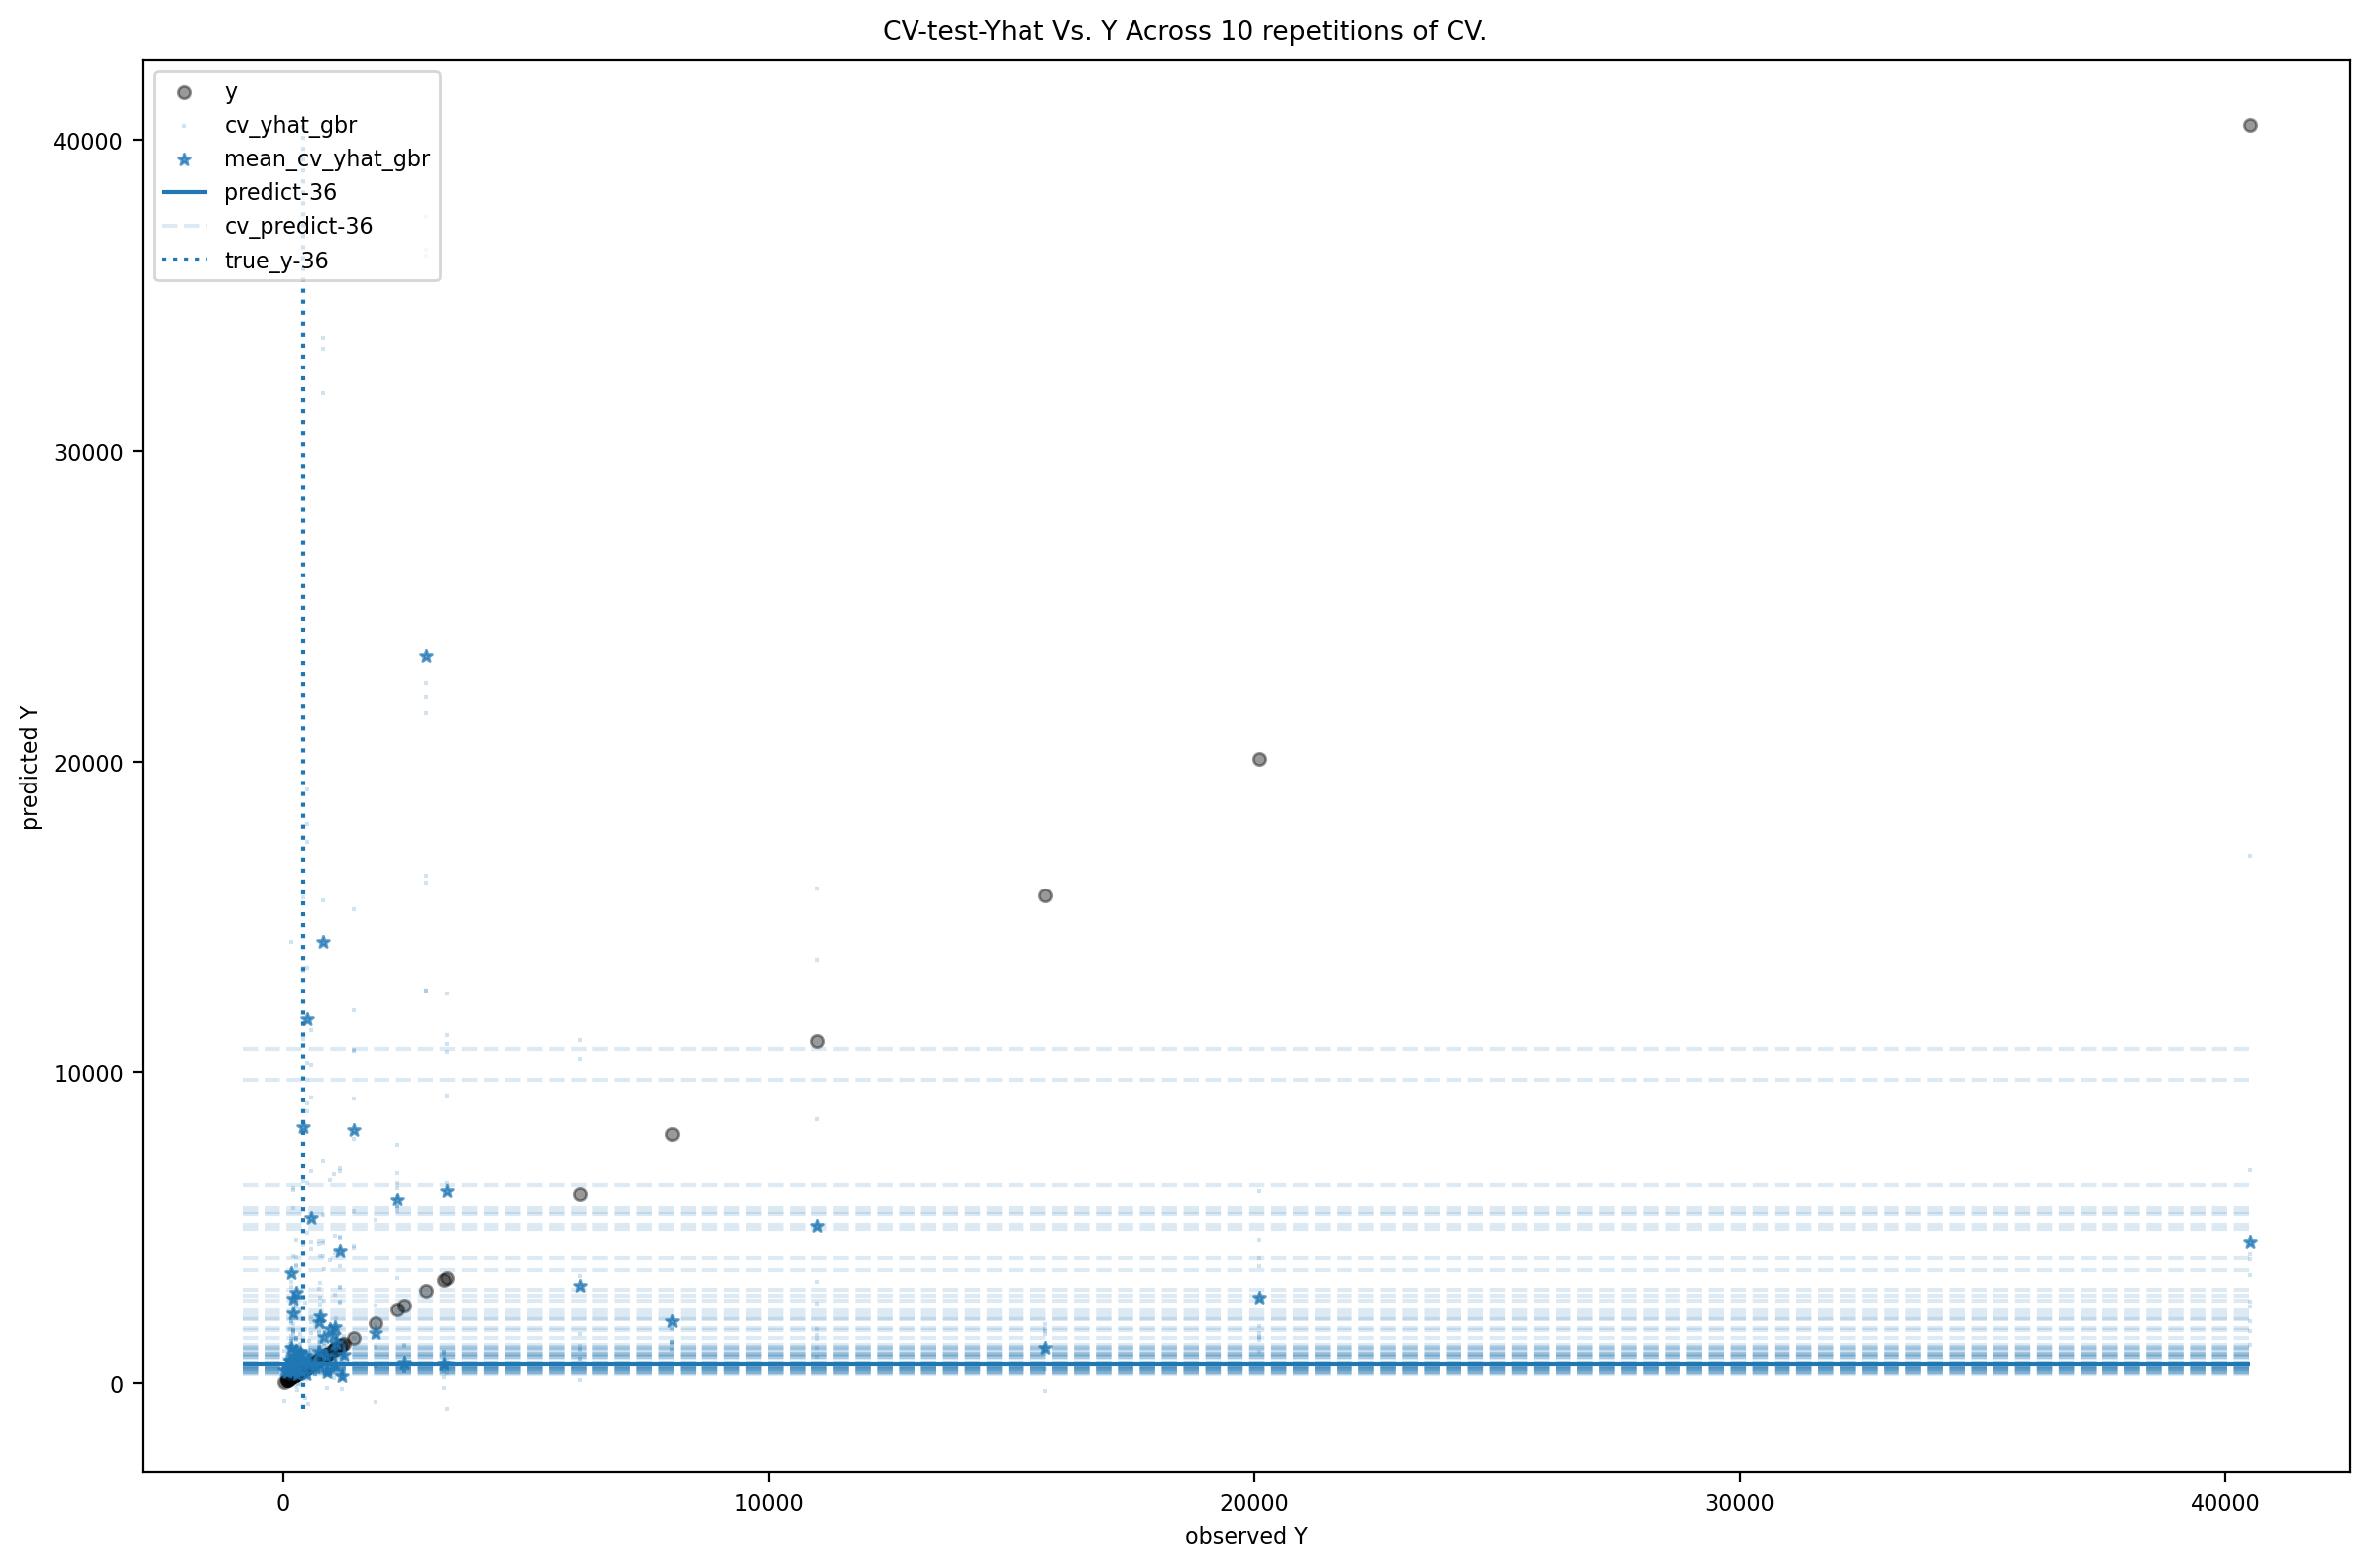

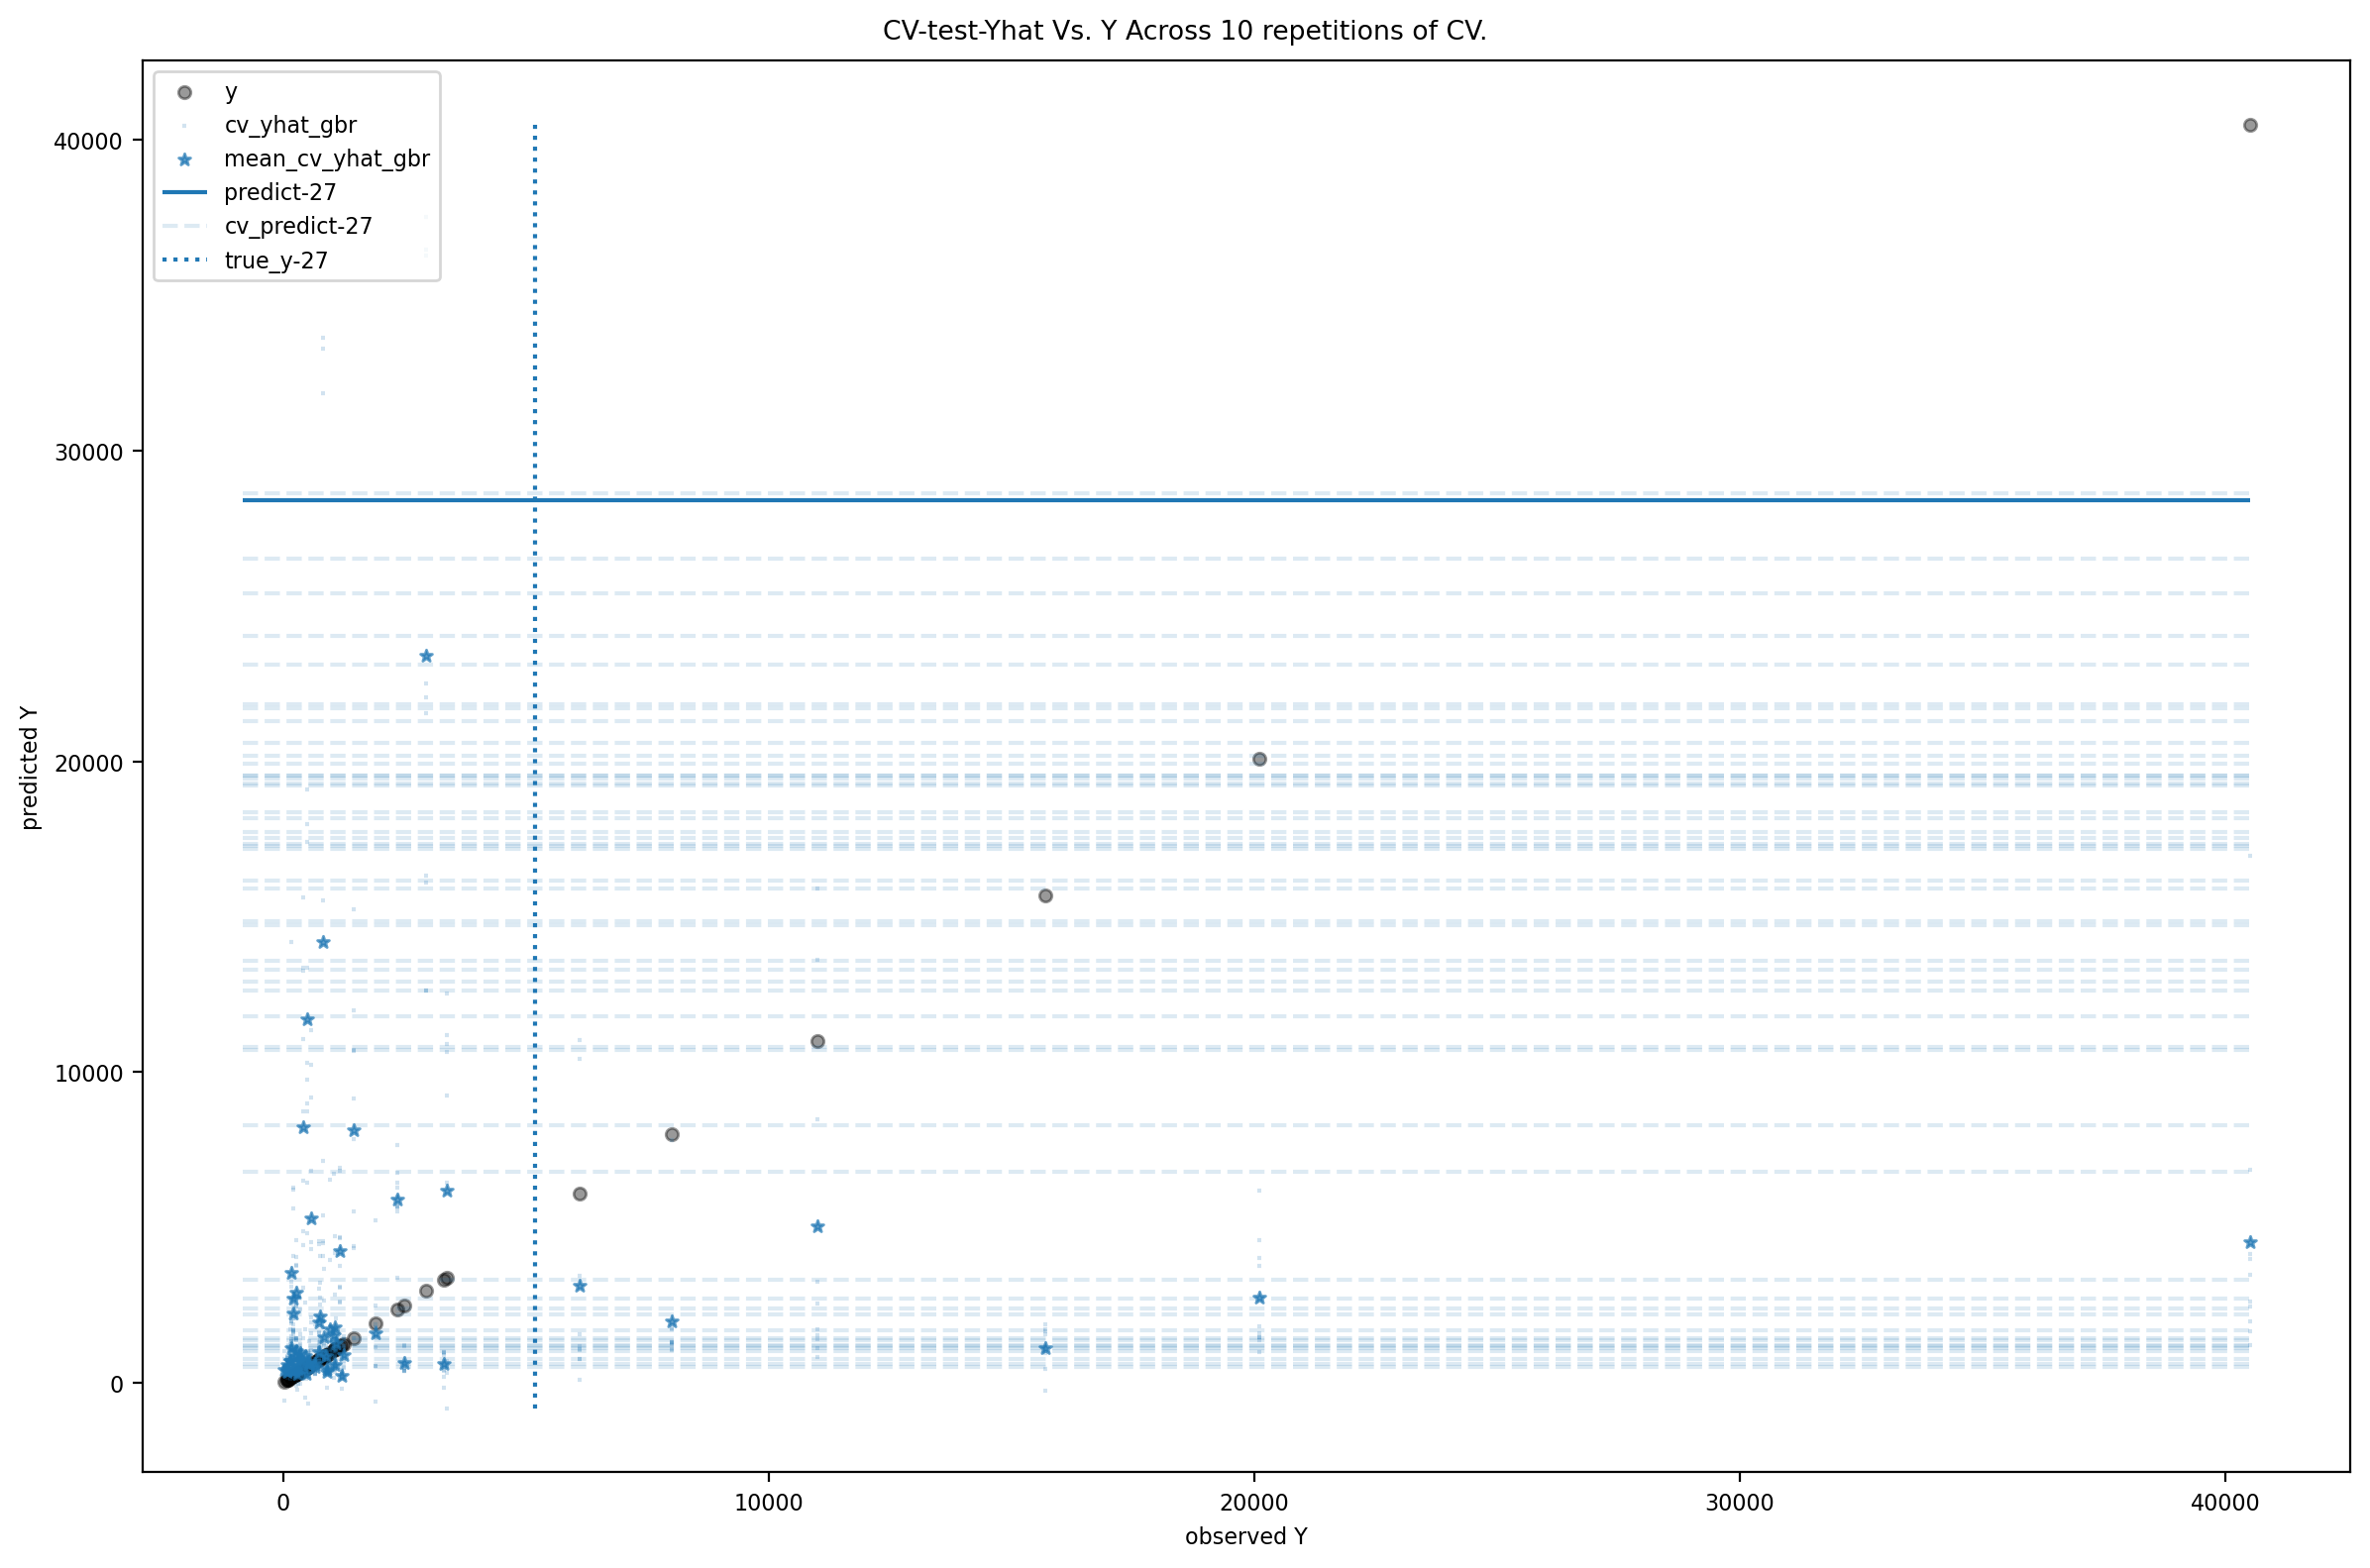

In [37]:
plotters=[VBPlotter() for _ in range(predict_n)]
for p in plotters: p.setData(cv_results_and_scores)
for i in range(predict_n): plotters[i].setPredictData(project_prediction_results,loc_row=y_predict.index[i])
for i in range(predict_n): plotters[i].plotCVYhatVsY(**p_kwargs,true_y=y_predict.loc[[y_predict.index[i]]])